# Projet d'Analyse de Données de Capteurs pour la Classification d'Exercices

**Auteurs :** *DAUVERGNE Florian - SIVAKANTHAN Nithusan - PORTIER Léo*

Ce projet a pour objectif d'analyser des données provenant de différents capteurs (EMG, IMU, IPS, COP, MOCAP) afin de classifier divers types d'exercices physiques. 

Pour ce faire, nous employons des approches de deep learning, en particulier des architectures combinant des réseaux convolutifs (CNN) et des réseaux de neurones à mémoire longue à court terme (LSTM), afin d'effectuer cette classification avec une haute précision.

## Objectifs du Projet
- **Préparer les données** : Extraire les données des fichiers ZIP, nettoyer les informations, organiser les données par type de capteur et d'exercice.
- **Prétraiter les données** : Rééchantillonner les données à 60 Hz, normaliser les valeurs et créer des fenêtres glissantes pour l'analyse temporelle.
- **Tester différents modèles** : Comparer un modèle CNN-LSTM simple et un modèle CNN-LSTM multimodale, fusionnant les données de tous les capteurs.
- **Tester différentes méthodes de splitting** : Utiliser deux stratégies de validation (80% - 20% et Leave-One-Group-Out) pour comparer les performances des modèles sur des données de test.
- **Évaluer les performances** : Comparer les performances des modèles sur des données de test.

In [1]:
import os
import re
import zipfile
from io import StringIO

from IPython.display import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.layers import (
    LSTM,
    Concatenate,
    Conv1D,
    Dense,
    Dropout,
    Input,
    MaxPooling1D,
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical,plot_model

# 1. Extraction et transposition des fichiers

Notre première étape consiste à extraire les données brutes depuis un fichier ZIP. Ces données sont ensuite organisées de manière structurée par capteur et par type d'exercice. Nous mettons en place un système de filtrage pour exclure les fichiers système et autres éléments non pertinents pour notre analyse.

Les données brutes nécessitent une restructuration pour être exploitables. Nous effectuons une lecture systématique des fichiers CSV, suivie d'une transposition pour obtenir un format adapté à notre analyse. Cette étape inclut également une standardisation des noms de colonnes pour assurer la cohérence des données.

In [2]:
def transpose_data(input_file):
    # Charge le fichier CSV dans un DataFrame pandas
    data = pd.read_csv(input_file)
    
    # Identifie les colonnes qui ne sont pas numériques ou des chiffres, et les considère comme des clés
    non_numeric_keys = [key for key in data.keys() if not (isinstance(key, (int, float)) or key.isdigit())]
    
    # Renomme la première clé non numérique en 'ID' (clé primaire pour la transposition)
    data = data.rename(columns={non_numeric_keys[0]: 'ID'})
    
    # Définit la colonne 'ID' comme index, puis transpose les données
    data = data.set_index('ID').transpose()
    
    return data

def unzip_and_process_files(zip_file_path, extract_to_folder, ignore_patterns=None):    
    # Vérifie si le fichier ZIP existe
    if not os.path.exists(zip_file_path):
        print(f"Le fichier zip {zip_file_path} n'existe pas.")
        return
    
    # Vérifie si les fichiers sont déjà extraits dans le dossier de destination
    if os.path.exists(extract_to_folder):
        print(f"Le fichier est déjà décompressé dans {extract_to_folder}.")
        return
    
    # Crée le dossier de destination si il n'existe pas
    os.makedirs(extract_to_folder, exist_ok=True)

    # Liste des fichiers à ignorer (par défaut, rien à ignorer)
    if ignore_patterns is None:
        ignore_patterns = []
    
    try:
        # Ouvre le fichier ZIP pour extraction
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            # Liste tous les fichiers présents dans l'archive ZIP
            zip_files = zip_ref.namelist()

            # Extraire uniquement les fichiers qui ne sont pas dans les fichiers à ignorer
            for file_name in zip_files:
                # Si le fichier correspond à un des patterns à ignorer, on l'ignore
                if any(pattern in file_name for pattern in ignore_patterns):
                    continue  # Ignore ce fichier et passe au suivant
                
                # Si le fichier est un CSV, on applique la transposition
                if file_name.endswith('.csv'):
                    # Extrait le fichier CSV dans le dossier spécifié
                    zip_ref.extract(file_name, extract_to_folder)
                    
                    # Applique la transposition au fichier CSV extrait
                    file_path = os.path.join(extract_to_folder, file_name)
                    transposed_data = transpose_data(file_path)
                    
                    # Sauvegarde le fichier CSV transposé dans le même emplacement
                    transposed_data.to_csv(file_path, index=False)
                    print(f"Fichier transposé et extrait : {file_path}")
            
            # Message indiquant que l'extraction est terminée
            print(f"Extraction terminée dans {extract_to_folder}")
    
    # Gestion des erreurs si le fichier ZIP est invalide
    except zipfile.BadZipFile:
        print(f"Erreur : Le fichier {zip_file_path} n'est pas un fichier zip valide.")
    except Exception as e:
        # Capture d'autres erreurs
        print(f"Erreur lors de la décompression : {e}")

# Paramètres du fichier ZIP et du dossier de destination
zip_file_path = 'dataset.zip'
extract_to_folder = 'unprocessed_datasets' 

# Liste des fichiers à ignorer pendant l'extraction
ignore_patterns = ['.txt', '_MACOSX', '.DS_Store']

# Appel de la fonction pour décompresser et traiter les fichiers
unzip_and_process_files(zip_file_path, extract_to_folder, ignore_patterns)


Fichier transposé et extrait : unprocessed_datasets\1/back/emg_1.csv
Fichier transposé et extrait : unprocessed_datasets\1/back/imu_1.csv
Fichier transposé et extrait : unprocessed_datasets\1/back/cop_1.csv
Fichier transposé et extrait : unprocessed_datasets\1/back/mocap_1.csv
Fichier transposé et extrait : unprocessed_datasets\1/back/ips_1.csv
Fichier transposé et extrait : unprocessed_datasets\1/halfsquat/emg_1.csv
Fichier transposé et extrait : unprocessed_datasets\1/halfsquat/imu_1.csv
Fichier transposé et extrait : unprocessed_datasets\1/halfsquat/cop_1.csv
Fichier transposé et extrait : unprocessed_datasets\1/halfsquat/mocap_1.csv
Fichier transposé et extrait : unprocessed_datasets\1/halfsquat/ips_1.csv
Fichier transposé et extrait : unprocessed_datasets\1/still/emg_1.csv
Fichier transposé et extrait : unprocessed_datasets\1/still/imu_1.csv
Fichier transposé et extrait : unprocessed_datasets\1/still/cop_1.csv
Fichier transposé et extrait : unprocessed_datasets\1/still/mocap_1.csv

Notre jeu de données comprend des enregistrements de plusieurs patients réalisant différents types d'exercices. Les données sont collectées via divers capteurs, chacun ayant sa propre fréquence d'échantillonnage. 

Cette diversité des sources d'information enrichit notre analyse tout en présentant des défis d'harmonisation.

L'extraction terminée, nous faisons un parcours de tous les fichiers dans le dossier contenant les fichiers extraits et non traités (unprocessed_datasets) afin d'enregistrer dans des listes diverse informations comme les numéros de patients, les types d'exercices, les types de capteurs et les chemins de chaque fichier pour une utilisation ultérieure.


In [2]:
def extract_number_from_path(path):
    # Utiliser une expression régulière pour extraire le premier nombre dans le chemin
    match = re.search(r'\\(\d+)', path)  # Cherche un nombre qui suit un backslash
    if match:
        return int(match.group(1))  # Retourne le nombre trouvé en tant qu'entier
    return 0  # Si aucun nombre n'est trouvé, on retourne 0

def get_files_paths(directory_path):
    files_paths = []  # Liste pour stocker les chemins des fichiers trouvés
    
    # Parcourir les fichiers dans le répertoire et ses sous-répertoires
    for root, dir, files in os.walk(directory_path):
        for file_name in files:
            # Ajouter le chemin complet du fichier à la liste
            files_paths.append(os.path.join(root, file_name))

    return files_paths

# Utiliser la fonction pour obtenir tous les chemins des fichiers dans 'unprocessed_datasets'
# Trier les chemins de fichiers selon le premier nombre trouvé dans chaque chemin (en utilisant 'extract_number_from_path')
UNPROCESSED_FILES_PATH = sorted(get_files_paths('unprocessed_datasets'), key=extract_number_from_path)


In [3]:
def get_number_of_patient(files_paths):
    # Utiliser un ensemble (set) pour garder les numéros de patient uniques
    patient_numbers = set()

    # Parcourir les chemins de fichiers
    for file_path in files_paths:
        # Extraire le numéro de patient (le second élément du chemin)
        # On suppose que le numéro de patient est situé dans la deuxième position du chemin
        # par exemple : 'unprocessed_datasets\\1\\exercice\\sensor.csv'
        patient_number = file_path.split('\\')[1]
        
        # Ajouter le numéro de patient à l'ensemble
        # L'ensemble garantit l'unicité des numéros de patient
        patient_numbers.add(patient_number)

    # Retourner le nombre de patients uniques
    # La longueur de l'ensemble correspond au nombre de patients distincts
    return len(patient_numbers)

# Appel de la fonction pour obtenir le nombre de patients uniques à partir des chemins de fichiers
SAMPLE_SIZE = get_number_of_patient(UNPROCESSED_FILES_PATH)

# Afficher le nombre de patients
print(f"Nombre de patients : {SAMPLE_SIZE}")

Nombre de patients : 25


In [4]:
def get_exercice_type(files_paths):
    # Créer un ensemble pour stocker les types d'exercices uniques
    exercice_type = set()

    # Parcourir les chemins de fichiers
    for file_path in files_paths:
        # Extraire le numéro du patient à partir du chemin
        patient_number = file_path.split('\\')[1]
        
        # Si le numéro du patient n'est pas '1', on arrête la boucle
        if patient_number != '1':
            break 
        
        # Extraire le nom de l'exercice, qui se trouve dans le troisième élément du chemin
        exercice_name = file_path.split('\\')[2]
        
        # Ajouter le nom de l'exercice à l'ensemble
        exercice_type.add(exercice_name)

    # Retourner l'ensemble des types d'exercices uniques
    return exercice_type

# Obtenir les types d'exercices pour le patient '1' à partir de la liste des chemins de fichiers
EXERCICES_TYPE = get_exercice_type(UNPROCESSED_FILES_PATH)

# Afficher les types d'exercices extraits
print(f"Types d'exercices : {EXERCICES_TYPE}")


Types d'exercices : {'back', 'forward', 'halfsquat', 'still'}


Nous estimons la fréquence d'échantillonnage du capteur à partir de la durée de l'exercice. 

Nous obtenons des fréquences d'échantillonnage identiques au fréquences des capteurs.

In [5]:
def estimate_sampling_rate_from_duration(file_path, duration_seconds):
    # Lire le fichier CSV
    data = pd.read_csv(file_path)
    
    # Nombre d'échantillons dans le fichier
    num_samples = data.shape[0]
    
    # Estimer la fréquence d'échantillonnage : nombre d'échantillons / durée en secondes
    sampling_rate = round(num_samples / duration_seconds / 10) * 10
    
    # Retourner la fréquence d'échantillonnage estimée
    return round(sampling_rate)

def get_sensors_type_and_sampling_rate(files_paths):
    # Dictionnaire pour stocker les types de capteurs et leurs fréquences d'échantillonnage
    SENSORS_TYPE = {}
    
    # Durée des enregistrements, utilisée pour estimer la fréquence d'échantillonnage
    DURATION = 66.1  # Durée en secondes, par exemple 66.1 secondes pour chaque fichier

    # Parcourir les chemins des fichiers
    for file_path in files_paths:
        # Extraire le numéro du patient à partir du chemin
        patient_number = file_path.split('\\')[1]
        
        # Si le numéro du patient n'est pas '1', ignorer ce fichier
        if patient_number != '1':
            break  # Si on a traité le patient '1', on arrête l'analyse des autres patients
        
        # Extraire le nom du capteur à partir du chemin du fichier
        sensor_name = file_path.split('\\')[3].split('_')[0].replace('.csv', '')
        
        # Estimer la fréquence d'échantillonnage pour ce capteur
        sensor_rate = estimate_sampling_rate_from_duration(file_path, DURATION)
        
        # Ajouter le capteur et sa fréquence d'échantillonnage au dictionnaire si ce capteur n'existe pas déjà
        if sensor_name not in SENSORS_TYPE:
            SENSORS_TYPE[sensor_name] = sensor_rate

    # Retourner le dictionnaire des types de capteurs et leurs fréquences d'échantillonnage
    return SENSORS_TYPE

# Obtenir les types de capteurs et leurs fréquences d'échantillonnage
SENSORS_TYPE = get_sensors_type_and_sampling_rate(UNPROCESSED_FILES_PATH)

print("Types de capteurs détectés et leurs fréquences d'échantillonnage : ", SENSORS_TYPE)


Types de capteurs détectés et leurs fréquences d'échantillonnage :  {'cop': 60, 'emg': 2000, 'imu': 100, 'ips': 60, 'mocap': 100}


Une fois l'extraction des fichiers et des caractéristiques terminée, nous pouvons commencer l'analyse des données.

Cette analyse nous a permis d'identifier plusieurs caractéristiques importantes de notre jeu de données. 

Nous avons constaté que les capteurs fonctionnent à des fréquences d'échantillonnage différentes, allant de 60Hz à 200Hz selon le type de capteur. 

Nous avons aussi repéré la présence de valeurs manquantes pour des exercices chez certains patients, nécessitant un traitement particulier et plusieures sessions d'enregistrement, identifiées par des suffixes (_1, _2, _3), pour un même exercice.

# 2. Structuration et nettoyage des données pour l'analyse

Le nettoyage des données constitue une étape fondamentale de notre prétraitement.

Nous commençons par fusionner les enregistrements multiples d'un même exercice pour obtenir des séquences complètes et cohérentes.Les fichiers temporaires et les doublons sont ensuite supprimés pour éviter toute redondance.

In [7]:
# Parcours de tous les chemins de fichiers dans la liste UNPROCESSED_FILES_PATH
for file_path in UNPROCESSED_FILES_PATH:
    
    # Si le fichier contient '_1' dans son nom
    if('_1' in file_path):
        # Lire le fichier CSV et sauvegarder sous un nouveau nom sans '_1'
        pd.read_csv(file_path).to_csv(file_path.replace('_1',''), index=False)
        
        # Supprimer l'ancien fichier avec '_1' dans son nom
        os.remove(file_path)
        
    # Si le fichier contient '_2' dans son nom
    if('_2' in file_path):
        # Lire les données de deux fichiers, l'un avec '_2' et l'autre sans '_2'
        data_1 = pd.read_csv(file_path.replace('_2',''))  # Fichier sans '_2'
        data_2 = pd.read_csv(file_path)  # Fichier avec '_2'
        
        # Fusionner les deux ensembles de données
        pd.concat([data_1, data_2]).to_csv(file_path.replace('_2',''), index=False)
        
        # Supprimer l'ancien fichier avec '_2' dans son nom
        os.remove(file_path)
        
    # Si le fichier contient '_3' dans son nom
    if('_3' in file_path):
        # Lire les données de deux fichiers, l'un avec '_3' et l'autre sans '_3'
        data_1 = pd.read_csv(file_path.replace('_3',''))  # Fichier sans '_3'
        data_2 = pd.read_csv(file_path)  # Fichier avec '_3'
        
        # Fusionner les deux ensembles de données
        pd.concat([data_1, data_2]).to_csv(file_path.replace('_3',''), index=False)
        
        # Supprimer l'ancien fichier avec '_3' dans son nom
        os.remove(file_path)


In [6]:
def remove_suffix_and_duplicates(file_names):   
    # Liste qui contiendra les noms de fichiers nettoyés
    cleaned_files = []
    
    # Set utilisé pour garder une trace des fichiers déjà rencontrés
    seen = set()

    # Ce pattern capture tout avant un underscore suivi d'un chiffre (_n) et l'extension du fichier
    pattern = re.compile(r"(.*?)(_\d+)?\.[^\.]+$")  # Exemple : "file_1.csv" => "file"
    
    for file in file_names:
        # Appliquer l'expression régulière pour extraire la partie avant '_n' et l'extension
        match = pattern.match(file)
        
        if match:
            base_name = match.group(1)  # On récupère le nom de base sans le suffixe _n
            if base_name not in seen:
                # Si le fichier n'a pas encore été rencontré, on le garde dans la liste
                cleaned_files.append(file.replace('_1', ''))  # Enlève le suffixe '_1'
                seen.add(base_name)  # On ajoute le nom de base au set 'seen' pour éviter les doublons
        else:
            # Si le fichier ne correspond pas au pattern (ex. pas de suffixe '_n'), on l'ajoute tel quel
            cleaned_files.append(file.replace('_1', ''))  # On enlève '_1' s'il est présent
            seen.add(file)  # Ajout du fichier complet au set 'seen'

    # Retourne la liste des fichiers nettoyés, sans doublons
    return cleaned_files

# Appliquer cette fonction à la liste des fichiers non traités
UNPROCESSED_FILES_PATH = remove_suffix_and_duplicates(UNPROCESSED_FILES_PATH)

L'harmonisation des fréquences d'échantillonnage représente un défi majeur de notre prétraitement. 

Nous avons choisi de standardiser toutes nos données à 60Hz, correspondant à la fréquence la plus basse parmi nos capteurs. Cette transformation est réalisée par interpolation linéaire, permettant de préserver au mieux la dynamique des signaux.

Une attention particulière est portée à la vérification de la cohérence temporelle après rééchantillonnage.

Les valeurs aberrantes sont éliminées, tandis que les valeurs manquantes sont comblées par interpolation linéaire pour maintenir la continuité des signaux.

In [9]:
def resampling(dataset_wrong_frequency, dataset_desired_frequency, wrong_frequency, desired_frequency, debug=False):
    # Si les fréquences sont déjà égales, on renvoie simplement le dataset original sans modification
    if wrong_frequency == desired_frequency:
        return dataset_wrong_frequency
    
    # Création d'un DataFrame avec une nouvelle colonne 'time' pour les données avec une fréquence incorrecte
    df_wrong_Hz = dataset_wrong_frequency
    sampling_rate_wrong_Hz = wrong_frequency
    # Crée une série de temps basée sur la fréquence d'échantillonnage initiale (en microsecondes)
    df_wrong_Hz['time'] = pd.date_range(start='00:00:00', periods=df_wrong_Hz.shape[0], freq=f'{int(1e6 / sampling_rate_wrong_Hz)}us')

    # Nombre de points dans les données à la fréquence erronée
    n_points_wrong_Hz = len(df_wrong_Hz)
    
    # Nombre de points dans les données à la fréquence désirée
    n_points_desired_Hz = dataset_desired_frequency.shape[0]

    # Crée une série de temps avec la fréquence désirée
    time = pd.date_range(start=df_wrong_Hz['time'].iloc[0], periods=n_points_desired_Hz, freq=f'{int(desired_frequency/10)}ms')
    
    # Définit la colonne 'time' comme index
    df_wrong_Hz.set_index('time', inplace=True)
    
    # Rééchantillonne les données à la fréquence désirée en réindexant et en interpolant les valeurs manquantes
    df_wrong_Hz_resampled = df_wrong_Hz.reindex(time).interpolate(method='linear')

    # Si le mode debug est activé, affiche des informations sur le rééchantillonnage
    if debug == True:
        print(f"Nombre de points à {wrong_frequency} Hz avant interpolation:", n_points_wrong_Hz)
        print(f"Nombre de points à {desired_frequency} Hz après interpolation:", len(df_wrong_Hz_resampled))
    
    return df_wrong_Hz_resampled

Nous appliquons alors tous ces traitements à chaque fichier dans le dossier unprocessed_datasets et nous sauvegardons les fichiers traités dans le dossier processed_datasets.

In [10]:
# Création du dossier processed_datasets si ce n'est pas déjà fait
if not os.path.exists('processed_datasets'):
    os.makedirs('processed_datasets')

# Processus de rééchantillonnage pour chaque fichier non traité
for file_path in UNPROCESSED_FILES_PATH:
    # Chemin vers le dossier des fichiers traités
    PROCESSED_FILES_PATH = os.path.dirname(file_path.replace('unprocessed_datasets', 'processed_datasets'))
    
    # Si le dossier n'existe pas, le créer
    if not os.path.exists(PROCESSED_FILES_PATH):
        os.makedirs(PROCESSED_FILES_PATH)
    
    # Nom du capteur, extrait du chemin du fichier
    sensor_name = file_path.split('\\')[3].split('_')[0].replace('.csv','')
    
    # Fréquence de mesure du capteur (définie dans un dictionnaire global SENSORS_TYPE)
    sensor_rate = SENSORS_TYPE[sensor_name]
    
    # Si le fichier traité n'existe pas déjà
    if not os.path.exists(f'{PROCESSED_FILES_PATH}/{sensor_name}.csv'):
        # Applique le rééchantillonnage des données à 60 Hz (en utilisant un autre fichier comme référence)
        processed_data = resampling(pd.read_csv(file_path), pd.read_csv('unprocessed_datasets\\1\\back\\cop.csv'), sensor_rate, 60, debug=True)
        
        # Sauvegarde les données rééchantillonnées dans le dossier des fichiers traités
        processed_data.to_csv(f'{PROCESSED_FILES_PATH}/{sensor_name}.csv', index=False)
        
        # Affiche un message indiquant le rééchantillonnage
        print(f'{PROCESSED_FILES_PATH}/{sensor_name}.csv est passé de {sensor_rate} Hz à 60Hz')


processed_datasets\1\back/cop.csv est passé de 60 Hz à 60Hz
Nombre de points à 2000 Hz avant interpolation: 132440
Nombre de points à 60 Hz après interpolation: 3973
processed_datasets\1\back/emg.csv est passé de 2000 Hz à 60Hz
Nombre de points à 100 Hz avant interpolation: 6622
Nombre de points à 60 Hz après interpolation: 3973
processed_datasets\1\back/imu.csv est passé de 100 Hz à 60Hz
processed_datasets\1\back/ips.csv est passé de 60 Hz à 60Hz
Nombre de points à 100 Hz avant interpolation: 6622
Nombre de points à 60 Hz après interpolation: 3973
processed_datasets\1\back/mocap.csv est passé de 100 Hz à 60Hz
processed_datasets\1\forward/cop.csv est passé de 60 Hz à 60Hz
Nombre de points à 2000 Hz avant interpolation: 120160
Nombre de points à 60 Hz après interpolation: 3973
processed_datasets\1\forward/emg.csv est passé de 2000 Hz à 60Hz
Nombre de points à 100 Hz avant interpolation: 6008
Nombre de points à 60 Hz après interpolation: 3973
processed_datasets\1\forward/imu.csv est pass

Nous ajoutons les chemins des fichiers traités dans une liste.

In [ ]:
# Liste des fichiers traités
PROCESSED_FILES_PATH = sorted(get_files_paths('processed_datasets'), key=extract_number_from_path)

# 3. Création des datasets

Nous pouvons alors commencer à séparer nos données en deux ensembles distincts :

Le premier, que nous appelons "Split Normal", suit une répartition classique 80-20 entre données d'entraînement et de test. Nous créons un dossier 'normal_split' si ce n'est pas déjà fait dans lequel nous créons un fichier pour chaque capteur.

Ensuite, nous concaténons les données de chaque patient pour ce capteur et nous ajoutons une colonne label qui contient le type d'exercice.

Enfin, nous sauvegardons les données dans le dossier normal_split.

In [9]:
# Vérifier si le dossier 'normal_split' existe déjà
# Si ce n'est pas le cas, le créer
if not os.path.exists('normal_split'):
    os.makedirs('normal_split')  # Créer le dossier 'normal_split' si nécessaire

# Boucle sur chaque type de capteur dans SENSORS_TYPE
for sensor in SENSORS_TYPE:
    # Vérifier si le fichier CSV pour ce capteur existe déjà dans le dossier 'normal_split'
    if os.path.exists(f'normal_split/{sensor}.csv'):
        print(f'normal_split/{sensor}.csv existe déjà')  # Afficher un message si le fichier existe
        continue  # Passer au capteur suivant si le fichier existe déjà
    
    # Si le fichier n'existe pas, afficher un message et commencer sa création
    print(f'normal_split/{sensor}.csv en cours de création')
    
    # Créer un DataFrame vide pour stocker les données
    df = pd.DataFrame()

    # Boucle sur chaque exercice dans EXERCICES_TYPE
    for exercice in EXERCICES_TYPE:
        # Boucle sur un intervalle de 1 à SAMPLE_SIZE pour parcourir les différents échantillons
        for i in range(1, SAMPLE_SIZE + 1):
            try:
                # Lire le fichier CSV de données traité pour chaque exercice, sensor et échantillon
                data = pd.read_csv(f'processed_datasets/{i}/{exercice}/{sensor}.csv')
                data["label"] = exercice  # Ajouter une colonne 'label' correspondant à l'exercice actuel
                df = pd.concat([df, data], axis=0).reset_index(drop=True)  # Concaténer les données au DataFrame global
            except:
                continue  # Si une erreur se produit lors de la lecture du fichier, passer au fichier suivant

        # Sauvegarder le DataFrame combiné dans un fichier CSV pour ce capteur
        df.to_csv(f'normal_split/{sensor}.csv', index=False)

    print(f'normal_split/{sensor}.csv créé')  

normal_split/cop.csv en cours de création
normal_split/cop.csv créé
normal_split/emg.csv en cours de création
normal_split/emg.csv créé
normal_split/imu.csv en cours de création
normal_split/imu.csv créé
normal_split/ips.csv en cours de création
normal_split/ips.csv créé
normal_split/mocap.csv en cours de création
normal_split/mocap.csv créé


Le second ensemble, utilise une validation de type "Leave-One-Group-Out" (LOGO), où nous réservons les données de cinq patients pour le test, tandis que les vingt autres servent à l'entraînement. 

Nous créons un dossier 'logo_split' si ce n'est pas déjà fait dans lequel nous créons un fichier pour chaque capteur. Ensuite, nous concaténons les données de chaque patient pour ce capteur et nous ajoutons une colonne label qui contient le type d'exercice.

Nous ajoutons également une colonne patient qui contient le numéro du patient.

Enfin, nous sauvegardons les données dans le dossier logo_split.

In [10]:
# Vérifier si le dossier 'logo_split' existe déjà
# Si ce n'est pas le cas, le créer
if not os.path.exists('logo_split'):
    os.makedirs('logo_split')  # Créer le dossier 'logo_split' si nécessaire

# Boucle sur chaque type de capteur dans SENSORS_TYPE
for sensor in SENSORS_TYPE:
    # Vérifier si le fichier CSV pour ce capteur existe déjà dans le dossier 'logo_split'
    if os.path.exists(f'logo_split/{sensor}.csv'):
        print(f'logo_split/{sensor}.csv existe déjà')  # Afficher un message si le fichier existe
        continue  # Passer au capteur suivant si le fichier existe déjà
    
    # Si le fichier n'existe pas, afficher un message et commencer sa création
    print(f'logo_split/{sensor}.csv en cours de création')
    
    # Créer un DataFrame vide pour stocker les données
    df = pd.DataFrame()

    # Boucle sur chaque exercice dans EXERCICES_TYPE
    for exercice in EXERCICES_TYPE:
        # Boucle sur un intervalle de 1 à SAMPLE_SIZE pour parcourir les différents échantillons
        for i in range(1, SAMPLE_SIZE + 1):
            try:
                # Lire le fichier CSV de données traité pour chaque exercice, sensor et échantillon
                data = pd.read_csv(f'processed_datasets/{i}/{exercice}/{sensor}.csv')
                data["label"] = exercice  # Ajouter une colonne 'label' correspondant à l'exercice actuel
                data["patient"] = i  # Ajouter une colonne 'patient' pour l'échantillon actuel (numéro d'échantillon)
                df = pd.concat([df, data], axis=0).reset_index(drop=True)  # Concaténer les données au DataFrame global
            except:
                continue  # Si une erreur se produit lors de la lecture du fichier, passer au fichier suivant

        # Sauvegarder le DataFrame combiné dans un fichier CSV pour ce capteur
        df.to_csv(f'logo_split/{sensor}.csv', index=False)

    print(f'logo_split/{sensor}.csv créé')  

logo_split/cop.csv en cours de création
logo_split/cop.csv créé
logo_split/emg.csv en cours de création
logo_split/emg.csv créé
logo_split/imu.csv en cours de création
logo_split/imu.csv créé
logo_split/ips.csv en cours de création
logo_split/ips.csv créé
logo_split/mocap.csv en cours de création
logo_split/mocap.csv créé


L'équilibrage des classes représente un aspect crucial de notre prétraitement.

Nous récupérons alors le nombre de mesures par exercice et par capteur pour le Normal Split et le LOGO Split afin de les afficher dans des graphiques.


In [11]:
# Création de DataFrames vides pour stocker les résultats
# Les colonnes correspondent aux exercices et les index aux types de capteurs
number_of_measures_normal = pd.DataFrame(columns=list(EXERCICES_TYPE), index=list(SENSORS_TYPE.keys()))
number_of_measures_logo = pd.DataFrame(columns=list(EXERCICES_TYPE), index=list(SENSORS_TYPE.keys()))

# Boucle pour chaque exercice et chaque capteur
for exercice in EXERCICES_TYPE:
    for sensor in SENSORS_TYPE:
        # Charger les données des fichiers CSV respectifs pour 'normal_split' et 'logo_split'
        normal_data = pd.read_csv(f"normal_split/{sensor}.csv")
        logo_data = pd.read_csv(f"logo_split/{sensor}.csv")
        
        # Calculer le nombre de mesures pour chaque exercice dans 'normal_split'
        # Filtrer les données en fonction de l'exercice et compter les lignes
        number_of_measures_normal.loc[sensor, exercice] = normal_data[normal_data['label'] == exercice].shape[0]
        
        # Calculer le nombre de mesures pour chaque exercice dans 'logo_split'
        # Idem pour le jeu de données 'logo_split'
        number_of_measures_logo.loc[sensor, exercice] = logo_data[logo_data['label'] == exercice].shape[0]

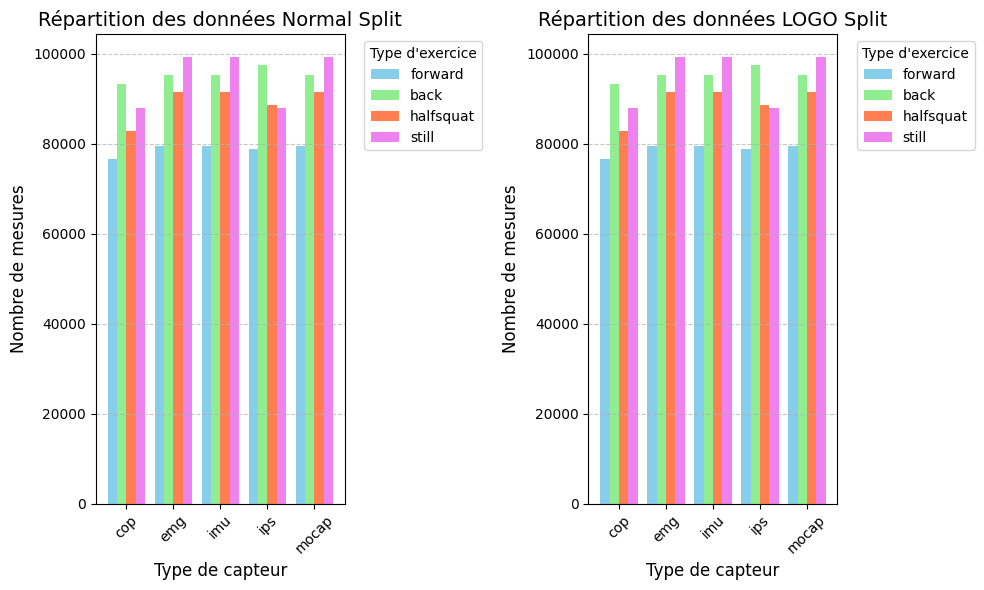

In [12]:
# Paramètres des graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))  # 1 ligne, 2 colonnes

# Graphique 1: Mesures Normal
number_of_measures_normal.plot(kind='bar', ax=ax1, width=0.8, color=['skyblue', 'lightgreen', 'coral', 'violet'])
ax1.set_xlabel("Type de capteur", fontsize=12)
ax1.set_ylabel("Nombre de mesures", fontsize=12)
ax1.set_title("Répartition des données Normal Split", fontsize=14)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.tick_params(axis='x', rotation=45)
ax1.legend(title="Type d'exercice", bbox_to_anchor=(1.05, 1), loc='upper left')


# Graphique 2: Mesures LOGO
number_of_measures_normal.plot(kind='bar', ax=ax2, width=0.8, color=['skyblue', 'lightgreen', 'coral', 'violet'])
ax2.set_xlabel("Type de capteur", fontsize=12)
ax2.set_ylabel("Nombre de mesures", fontsize=12)
ax2.set_title("Répartition des données LOGO Split", fontsize=14)
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.tick_params(axis='x', rotation=45)
ax2.legend(title="Type d'exercice", bbox_to_anchor=(1.05, 1), loc='upper left')


# Ajuster les espacements pour éviter le chevauchement
plt.tight_layout()

# Afficher les graphiques
plt.show()

Nous pouvons alors remarquer des déséquilibres dans la représentation des différents exercices

# 4. Équilibrage des Classes

Notre analyse initiale ayant révélé des déséquilibres dans la représentation des différents exercices, nous utilisons une combinaison de techniques de sur-échantillonnage (SMOTE) et de sous-échantillonnage pour obtenir des classes équilibrées. 

Cette étape est particulièrement importante pour éviter les biais dans l'apprentissage de nos modèles.

In [8]:
#Récupérer et trier les fichiers dans le répertoire 'normal_split' et 'logo_split' 
NORMAL_SPLIT_FILES_PATH = sorted(get_files_paths('normal_split'), key=extract_number_from_path)
LOGO_SPLIT_FILES_PATH = sorted(get_files_paths('logo_split'), key=extract_number_from_path)

Le but de l'équilibrage est d'obtenir 100 000 échantillions par classe

In [14]:
def check_class_balance(y, target_count=100000):
    # Calcule la répartition des classes dans la série 'y' en comptant le nombre d'occurrences de chaque classe
    class_counts = y.value_counts()
    
    # Vérifie si toutes les classes ont le même nombre d'occurrences que la valeur cible 'target_count'
    balanced = all(count == target_count for count in class_counts)
    
    # Si les classes ne sont pas équilibrées, affiche un message indiquant la répartition actuelle
    if not balanced:
        print(f"Classes are not balanced. Current class distribution: {class_counts}")
    
    # Retourne True si les classes sont équilibrées, sinon False
    return balanced


Tout d'abord, nous commençons par charger les fichiers CSV à partir du chemin spécifié. Ensuite nous supprimons les lignes contenant des valeurs manquantes. 

Nous séparons les caractéristiques (X) des labels (y) pour analyser la distribution des classes dans les données. Si la taille du jeu de données est inférieure à 400 000 échantillons, nous procédons à un rééchantillonnage pour équilibrer les classes. 

Si une classe est sur-représentée (plus de 100 000 échantillons), nous appliquons un sous-échantillonnage aléatoire (Random Under-Sampling) pour réduire la taille des classes les plus présentes. 

Si toutes les classes sont sous-représentées ou équilibrées, nous utilisons SMOTE (Synthetic Minority Over-sampling Technique) pour générer des exemples synthétiques et équilibrer les classes. 

Après chaque rééchantillonnage, nous vérifions si l'équilibre des classes est atteint.  Si les classes sont équilibrées, nous sauvegardons les données rééchantillonnées dans le fichier original, sinon nous continuons avec une nouvelle tentative. 

Ce processus est répété pour chaque fichier de données spécifié dans la liste NORMAL_SPLIT_FILES_PATH.

In [15]:
def resample_and_check(file_path, max_attempts=3):
    # Chargement du fichier CSV dans un DataFrame
    df = pd.read_csv(file_path)

    # Suppression des lignes contenant des valeurs manquantes
    df.dropna(inplace=True)

    # Initialisation du compteur de tentatives
    attempts = 0
    
    # Boucle jusqu'à max_attempts pour essayer de rééchantillonner si nécessaire
    while attempts < max_attempts:
        # Séparation des caractéristiques (X) et des labels (y)
        X = df.drop(columns=['label'])
        y = df['label']
        
        # Vérification de la répartition des classes actuelles
        current_class_counts = y.value_counts()
        print(f"Initial class distribution for {file_path}: {current_class_counts}")

        # Si le nombre total d'échantillons n'est pas égal à 400000, rééchantillonner
        if X.shape[0] != 400000:
            print(f"Before SMOTE or Under-Sampling to {file_path}, attempt {attempts + 1}")
            print(X.shape, y.shape)
            
            # Vérification si une classe a plus d'échantillons que la cible de 100000
            if any(current_class_counts[exercice] > 100000 for exercice in EXERCICES_TYPE):
                # Si oui, appliquer le Random Under-Sampling pour équilibrer
                print("Applying Random Under-Sampling due to over-represented classes")
                sampling_strategy = {exercice: min(100000, current_class_counts[exercice]) for exercice in EXERCICES_TYPE}
                under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
                X_resampled, y_resampled = under_sampler.fit_resample(X, y)
                
                # Affichage de la nouvelle répartition des classes après Under-Sampling
                print(f"After under-sampling, class distribution: {pd.Series(y_resampled).value_counts()}")
                
                # Fusionner les données rééchantillonnées dans un DataFrame
                balanced_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), 
                                        pd.DataFrame({'label': y_resampled})], axis=1)
                
                # Sauvegarder le DataFrame rééchantillonné dans un nouveau fichier CSV
                df = balanced_df
            else:
                # Sinon, appliquer SMOTE
                print("Applying SMOTE to balance the classes")
                sampling_strategy = {exercice: 100000 for exercice in EXERCICES_TYPE}
                smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
                X_resampled, y_resampled = smote.fit_resample(X, y)
                
                # Fusionner les données rééchantillonnées dans un DataFrame
                balanced_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), 
                        pd.DataFrame({'label': y_resampled})], axis=1)
                
                # Sauvegarder le DataFrame rééchantillonné dans un nouveau fichier CSV
                df = balanced_df
                print(f"After SMOTE, class distribution: {pd.Series(y_resampled).value_counts()}")

            # Vérification de l'équilibre des classes après rééchantillonnage
            if check_class_balance(y_resampled):
                # Si les classes sont équilibrées, sauvegarder le DataFrame rééchantillonné
                balanced_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), 
                                        pd.DataFrame({'label': y_resampled})], axis=1)
                balanced_df.to_csv(file_path, index=False)
                print(f"Successfully balanced and saved {file_path}")
                break
            else:
                # Si les classes ne sont toujours pas équilibrées après rééchantillonnage
                print(f"Warning: Classes are still not balanced in {file_path} after attempt {attempts + 1}")
                
        else:
            # Si les données sont déjà équilibrées (400000 échantillons), pas besoin de rééchantillonner
            print(f"Already balanced {file_path}")
            break

        # Augmenter le nombre de tentatives
        attempts += 1
        
        # Si le nombre d'essais atteint le maximum, avertir l'utilisateur
        if attempts >= max_attempts:
            print(f"Max attempts reached for {file_path}. Consider adjusting strategy or target count.")

# Appliquer la fonction sur tous les fichiers dans la liste NORMAL_SPLIT_FILES_PATH
for file_path in NORMAL_SPLIT_FILES_PATH:
    resample_and_check(file_path)


Initial class distribution for normal_split\cop.csv: label
back         93152
still        87904
forward      76512
halfsquat    74669
Name: count, dtype: int64
Before SMOTE or Under-Sampling to normal_split\cop.csv, attempt 1
(332237, 10) (332237,)
Applying SMOTE to balance the classes
After SMOTE, class distribution: label
forward      100000
back         100000
halfsquat    100000
still        100000
Name: count, dtype: int64
Successfully balanced and saved normal_split\cop.csv
Initial class distribution for normal_split\emg.csv: label
still        99325
back         95352
halfsquat    91379
forward      79460
Name: count, dtype: int64
Before SMOTE or Under-Sampling to normal_split\emg.csv, attempt 1
(365516, 16) (365516,)
Applying SMOTE to balance the classes
After SMOTE, class distribution: label
forward      100000
back         100000
halfsquat    100000
still        100000
Name: count, dtype: int64
Successfully balanced and saved normal_split\emg.csv
Initial class distribution f

Nous appliquons ensuite le même procédé pour chaque fichier de données spécifié dans la liste LOGO_SPLIT_FILES_PATH.

Mais, il existe une différence entre les données LOGO et Normal. Les données LOGO possède un champ contenant le numéro du patient ce qui va modifier la manière de gérer l'équilibrage des données.

En effet, il faut séparer le numéro du patient lors de la création des nouvelles données afin de ne générer que des données de capteurs.

Nous attribuons par la suite une numéro de patient aléatoire au données générées.

In [16]:
def resample_and_check_LOGO(file_path, max_attempts=3):
    # Chargement du fichier CSV dans un DataFrame
    df = pd.read_csv(file_path)
    
    # Suppression des lignes contenant des valeurs manquantes
    df.dropna(inplace=True)
    
    # Initialisation du compteur de tentatives
    attempts = 0
    
    # Boucle jusqu'à max_attempts pour essayer de rééchantillonner si nécessaire
    while attempts < max_attempts:
        # Séparation des caractéristiques (X), des labels (y) et des patients (z)
        X = df.drop(columns=['label','patient'])  # Caractéristiques (en excluant 'label' et 'patient')
        y = df['label']  # Labels
        z = df['patient']  # Identifiant des patients
        
        # Vérification de la répartition des classes actuelles
        current_class_counts = y.value_counts()
        print(f"Initial class distribution for {file_path}: {current_class_counts}")
        
        # Si le nombre total d'échantillons n'est pas égal à 400000, rééchantillonner
        if X.shape[0] != 400000:
            print(f"Before SMOTE or Under-Sampling to {file_path}, attempt {attempts + 1}")
            print(X.shape, y.shape)
            
            # Appliquer un Random Under-Sampling si une classe a plus d'échantillons que la cible de 100000
            if any(current_class_counts[exercice] > 100000 for exercice in EXERCICES_TYPE):
                print("Applying Random Under-Sampling due to over-represented classes")
                
                # Définir la stratégie de rééchantillonnage pour chaque classe
                sampling_strategy = {exercice: min(100000, current_class_counts[exercice]) for exercice in EXERCICES_TYPE}
                under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
                X_resampled, y_resampled = under_sampler.fit_resample(X, y)
                
                # Affichage de la nouvelle répartition des classes après sous-échantillonnage
                print(f"After under-sampling, class distribution: {pd.Series(y_resampled).value_counts()}")
                
                # Fusionner les données rééchantillonnées avec les informations des patients (z)
                balanced_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), 
                                         pd.DataFrame({'label': y_resampled}), 
                                         pd.DataFrame({'patient': z.iloc[:len(y_resampled)]})], axis=1)
                # Sauvegarder le DataFrame rééchantillonné dans un nouveau fichier CSV
                balanced_df.dropna(inplace=True)
                df = balanced_df
            else:
                # Appliquer SMOTE (Synthetic Minority Over-sampling Technique) pour ajuster la taille des classes
                print("Applying SMOTE to balance the classes")
                sampling_strategy = {exercice: 100000 for exercice in EXERCICES_TYPE}
                smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
                X_resampled, y_resampled = smote.fit_resample(X, y)
                
                # Fusionner les données rééchantillonnées avec les informations des patients (z)
                balanced_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), 
                                         pd.DataFrame({'label': y_resampled}), 
                                         pd.DataFrame({'patient': z.iloc[:len(y_resampled)]})], axis=1)
                df = balanced_df
                print(f"After SMOTE, class distribution: {pd.Series(y_resampled).value_counts()}")

            # Vérification de l'équilibre des classes après rééchantillonnage
            if check_class_balance(y_resampled):
                # Si les classes sont équilibrées, sauvegarder le DataFrame rééchantillonné
                balanced_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), 
                                         pd.DataFrame({'label': y_resampled}), 
                                         pd.DataFrame({'patient': z})], axis=1)
                
                # Remplacer les valeurs NaN dans la colonne 'patient' par un entier aléatoire entre 1 et 25
                balanced_df['patient'] = balanced_df['patient'].apply(lambda x: np.random.randint(1, 26) if pd.isna(x) else x)
                
                # Sauvegarder le DataFrame rééchantillonné dans un nouveau fichier CSV
                balanced_df.to_csv(file_path, index=False)
                print(f"Successfully balanced and saved {file_path}")
                break
            else:
                # Si les classes ne sont toujours pas équilibrées après rééchantillonnage
                print(f"Warning: Classes are still not balanced in {file_path} after attempt {attempts + 1}")
                
        else:
            # Si les données sont déjà équilibrées (400000 échantillons), pas besoin de rééchantillonner
            print(f"Already balanced {file_path}")
            break

        # Augmenter le nombre de tentatives
        attempts += 1
        
        # Si le nombre d'essais atteint le maximum, avertir l'utilisateur
        if attempts >= max_attempts:
            print(f"Max attempts reached for {file_path}. Consider adjusting strategy or target count.")

# Appliquer la fonction sur tous les fichiers dans la liste LOGO_SPLIT_FILES_PATH
for file_path in LOGO_SPLIT_FILES_PATH:
    resample_and_check_LOGO(file_path)

Initial class distribution for logo_split\cop.csv: label
back         93152
still        87904
forward      76512
halfsquat    74669
Name: count, dtype: int64
Before SMOTE or Under-Sampling to logo_split\cop.csv, attempt 1
(332237, 10) (332237,)
Applying SMOTE to balance the classes
After SMOTE, class distribution: label
forward      100000
back         100000
halfsquat    100000
still        100000
Name: count, dtype: int64
Successfully balanced and saved logo_split\cop.csv
Initial class distribution for logo_split\emg.csv: label
still        99325
back         95352
halfsquat    91379
forward      79460
Name: count, dtype: int64
Before SMOTE or Under-Sampling to logo_split\emg.csv, attempt 1
(365516, 16) (365516,)
Applying SMOTE to balance the classes
After SMOTE, class distribution: label
forward      100000
back         100000
halfsquat    100000
still        100000
Name: count, dtype: int64
Successfully balanced and saved logo_split\emg.csv
Initial class distribution for logo_spli

Une fois les données équilibrées nous affichons de nouveau leurs distributions.

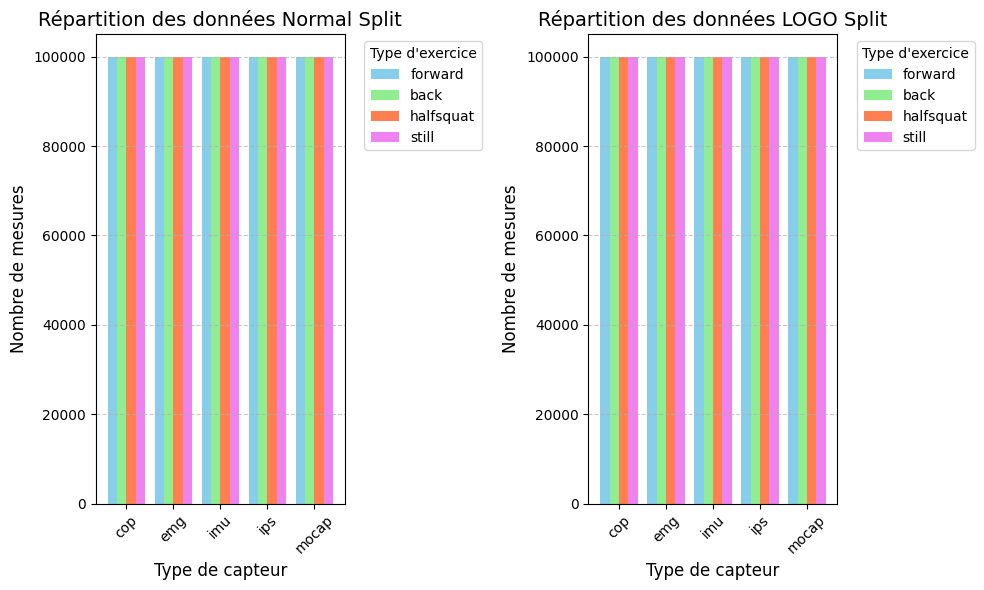

In [17]:
"""Réutilisation du code pour récupérer les données et afficher sous forme de graphe"""

number_of_measures_normal = pd.DataFrame(columns=list(EXERCICES_TYPE), index=list(SENSORS_TYPE.keys()))
number_of_measures_logo = pd.DataFrame(columns=list(EXERCICES_TYPE), index=list(SENSORS_TYPE.keys()))

for exercice in EXERCICES_TYPE:
    for sensor in SENSORS_TYPE:
        normal_data = pd.read_csv(f"normal_split/{sensor}.csv")
        logo_data = pd.read_csv(f"logo_split/{sensor}.csv")
        number_of_measures_normal.loc[sensor,exercice] = normal_data[normal_data['label'] == exercice].shape[0]
        number_of_measures_logo.loc[sensor,exercice] = logo_data[logo_data['label'] == exercice].shape[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

number_of_measures_normal.plot(kind='bar', ax=ax1, width=0.8, color=['skyblue', 'lightgreen', 'coral', 'violet'])
ax1.set_xlabel("Type de capteur", fontsize=12)
ax1.set_ylabel("Nombre de mesures", fontsize=12)
ax1.set_title("Répartition des données Normal Split", fontsize=14)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.tick_params(axis='x', rotation=45)

ax1.legend(title="Type d'exercice", bbox_to_anchor=(1.05, 1), loc='upper left')

number_of_measures_normal.plot(kind='bar', ax=ax2, width=0.8, color=['skyblue', 'lightgreen', 'coral', 'violet'])
ax2.set_xlabel("Type de capteur", fontsize=12)
ax2.set_ylabel("Nombre de mesures", fontsize=12)
ax2.set_title("Répartition des données LOGO Split", fontsize=14)
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.tick_params(axis='x', rotation=45)

ax2.legend(title="Type d'exercice", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

plt.show()

Nous pouvons alors remarquer qu'il n'y a plus de déséquilibre entre les différentes catécories

## 4. Création des données d'entrainement et de test pour le normal split

Nous allons maintenant préparer nos données pour l'entraînement des modèles utilisant les données de normal split.


L'architecture unifiée consiste à combiner les différentes modalités d'entrée (telles que EMG, IMU, IPS, COP, MOCAP) en un seul vecteur. Nous concatenons donc toutes les données présente dans le dossier 'normal split'

In [9]:
# Création d'un DataFrame vide pour stocker les données combinées
combined_df = pd.DataFrame()

# Boucle sur chaque type de capteur dans la liste SENSORS_TYPE
for sensor in SENSORS_TYPE:
    
    # Lecture des données depuis le fichier CSV correspondant à ce capteur
    data = pd.read_csv(f"normal_split/{sensor}.csv")
    
    # Si la colonne 'label' existe déjà dans combined_df, elle est supprimée pour éviter les doublons
    # 'errors="ignore"' assure qu'aucune erreur n'est levée si la colonne 'label' n'existe pas
    combined_df.drop(columns=['label'], inplace=True, errors='ignore')
    
    # Concaténation des données lues (data) au DataFrame combiné (combined_df)
    # Les nouvelles données sont ajoutées horizontalement (axis=1)
    combined_df = pd.concat([combined_df, data], axis=1)

# Afficher le DataFrame
combined_df.head()

,L_force,R_force,L_cop_x,L_cop_y,R_cop_x,R_cop_y,L_cop_col,L_cop_row,R_cop_col,R_cop_row,...,L_LM_x,L_LM_y,L_LM_z,L_CAL_x,L_CAL_y,L_CAL_z,L_MH1_x,L_MH1_y,L_MH1_z,label
0,367.862947,386.250163,0.234623,0.322513,0.276306,-0.064774,6.20,15.00,6.59,14.01,...,0.171851,0.323907,0.099630,0.098099,0.257530,0.038906,0.378321,0.346032,0.043509,forward
1,367.304960,385.380230,0.234408,0.322406,0.276087,-0.064662,6.19,15.03,6.60,14.04,...,0.171848,0.323912,0.099630,0.098101,0.257531,0.038903,0.378319,0.346030,0.043509,forward
2,368.974528,387.120096,0.234187,0.322308,0.275852,-0.064574,6.20,15.06,6.60,14.07,...,0.171845,0.323917,0.099630,0.098103,0.257532,0.038900,0.378317,0.346027,0.043509,forward
3,368.974528,386.250163,0.233961,0.322200,0.275937,-0.064603,6.21,15.09,6.60,14.06,...,0.171842,0.323923,0.099629,0.098105,0.257533,0.038898,0.378315,0.346025,0.043508,forward
4,368.974528,386.250163,0.233738,0.322105,0.276169,-0.064702,6.21,15.12,6.60,14.03,...,0.171839,0.323928,0.099629,0.098106,0.257534,0.038895,0.378314,0.346023,0.043508,forward


La fonction `create_windows` est une composante essentielle de notre prétraitement.

Elle permet de :
- Découper les données en séquences temporelles de taille fixe
- Associer chaque séquence à son label correspondant
- Préparer les données dans un format adapté pour les réseaux de neurones

In [10]:
# Fonction pour créer des fenêtres glissantes à partir des données
def create_windows(data, window_size, step_size):
    # Initialisation de deux listes vides pour stocker les fenêtres et les labels
    windows = []
    labels = []

    # Boucle pour découper les données en fenêtres glissantes
    # 'start' est l'index du début de la fenêtre
    # 'end' est l'index de la fin de la fenêtre (start + window_size)
    for start in range(0, len(data) - window_size, step_size):
        end = start + window_size
        
        # Créer la fenêtre en excluant la colonne 'label' (pour avoir uniquement les features)
        window = data[start:end].drop('label', axis=1)  # Exclure la colonne 'label'
        
        # Ajouter la fenêtre (toutes les lignes sauf la dernière) à la liste windows
        windows.append(window[:-1])  # On ne garde pas la dernière ligne de la fenêtre pour éviter les problèmes de dimensions
        
        # Définir l'étiquette correspondante à la fenêtre
        # On prend l'étiquette située à la fin de la fenêtre (end-1)
        # Cela suppose que l'étiquette associée à la fenêtre correspond à la classe du dernier point de la fenêtre
        labels.append(data.iloc[end - 1]['label'])  # Utiliser l'étiquette à la fin de la fenêtre
    
    # Conversion des listes en tableaux numpy pour pouvoir les utiliser avec Keras
    X = np.array(windows)  # Ce sont les données des fenêtres
    y = np.array(labels)   # Ce sont les labels associés aux fenêtres

    # Retourner les données de fenêtres et les étiquettes
    return X, y

Les paramètres choisis (window_size = 60, step_size = 60) correspondent à des fenêtres d'une seconde sans chevauchement, ce qui offre un bon compromis entre la quantité de données et la pertinence des séquences.

In [ ]:
# Paramètres de la fenêtre
window_size = 60  # Taille de la fenêtre (60 échantillons pour 1 seconde)
step_size = 60  # Pas de la fenêtre (60 échantillons pour pas de chevauchement)

Nous créons maintenant des fenêtres temporelles spécifiques pour chaque type d'architecture. 

Cette approche nous permettra d'alimenter notre modèle multimodal avec des données structurées par capteur et notre modèle unifié avec des données concaténées. 

In [157]:
# Segmenter les données en fenêtres
X, y = create_windows(combined_df, window_size, step_size)

# Affichage des dimensions des données segmentées
print(f'X shape: {X.shape}, y shape: {y.shape}')

# Création des fenêtres glissantes à partir des données du fichier 'ips.csv'
X_ips, _ = create_windows(pd.read_csv("normal_split/ips.csv"), window_size, step_size)

# Création des fenêtres glissantes à partir des données du fichier 'emg.csv'
X_emg, _ = create_windows(pd.read_csv("normal_split/emg.csv"), window_size, step_size)

# Création des fenêtres glissantes à partir des données du fichier 'imu.csv'
X_imu, _ = create_windows(pd.read_csv("normal_split/imu.csv"), window_size, step_size)

# Création des fenêtres glissantes à partir des données du fichier 'cop.csv'
X_cop, _ = create_windows(pd.read_csv("normal_split/cop.csv"), window_size, step_size)

# Création des fenêtres glissantes à partir des données du fichier 'mocap.csv'
X_mocap, _ = create_windows(pd.read_csv("normal_split/mocap.csv"), window_size, step_size)

# Créer un tableau pour afficher les formes des DataFrames
multimodal_shape = {
    'Capteur': ['IPS', 'EMG', 'IMU', 'COP', 'MOCAP'],
    'Forme (X)': [
        X_ips.shape,
        X_emg.shape,
        X_imu.shape,
        X_cop.shape,
        X_mocap.shape
    ]
}

# Convertir en DataFrame pour afficher sous forme de table
df_shapes = pd.DataFrame(multimodal_shape)

df_shapes

,Capteur,Forme (X)
0,IPS,"(6666, 59, 682)"
1,EMG,"(6666, 59, 16)"
2,IMU,"(6666, 59, 54)"
3,COP,"(6666, 59, 10)"
4,MOCAP,"(6666, 59, 78)"


La normalisation est une étape cruciale pour assurer une bonne convergence des modèles. 

Nous appliquons une normalisation StandardScaler individuellement pour chaque fenêtre temporelle de type de capteur séparément en préservant la structure temporelle des données.

Cette approche permet de maintenir les relations temporelles tout en standardisant l'échelle des données.

In [14]:
# Crée une instance de StandardScaler, qui sera utilisée pour normaliser les données
scaler = StandardScaler()

# Applique la normalisation à chaque fenêtre de données dans X
# La méthode fit_transform effectue l'ajustement et la transformation de chaque fenêtre de données individuellement
X_scaled = np.array([scaler.fit_transform(window) for window in X])

# Répète le même processus pour les données EMG
X_emg_scaled = np.array([scaler.fit_transform(window) for window in X_emg])

# Répète le même processus pour les données IMU
X_imu_scaled = np.array([scaler.fit_transform(window) for window in X_imu])

# Répète le même processus pour les données IPS
X_ips_scaled = np.array([scaler.fit_transform(window) for window in X_ips])

# Répète le même processus pour les données COP
X_cop_scaled = np.array([scaler.fit_transform(window) for window in X_cop])

# Répète le même processus pour les données MOCAP
X_mocap_scaled = np.array([scaler.fit_transform(window) for window in X_mocap])


Nous procédons à l'encodage des labels en deux étapes :
- Conversion des labels textuels en valeurs numériques via LabelEncoder
- Transformation en encodage one-hot pour la classification multiclasse

Cette représentation permet une meilleure gestion de la classification par nos modèles de deep learning.

In [15]:
# Crée une instance de LabelEncoder, utilisé pour encoder les étiquettes en valeurs numériques
label_encoder = LabelEncoder()

# Applique l'encodage sur les étiquettes y
# Ensuite, 'to_categorical' transforme ces entiers en vecteurs binaires (one-hot encoding)
y_encoded = to_categorical(label_encoder.fit_transform(y), num_classes=4)


### 4.5 Création des ensembles d'entraînement et de test

Nous divisons nos données en ensembles d'entraînement et de test selon deux approches :
- Pour le modèle unifié, utilisant l'ensemble des caractéristiques
- Pour le modèle multimodal, en séparant les données par type de capteur

Cette organisation nous permettra de comparer efficacement les performances des deux approches.

In [158]:
# Création des données de tests et d'entrainement pour l'architecture unifiée
# Divise les données en ensembles d'entraînement et de test
# 'X_scaled' contient les caractéristiques (données normalisées), 'y_encoded' contient les étiquettes encodées
# 20% des données seront utilisées pour le test, et 80% pour l'entraînement
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Affiche la forme des ensembles d'entraînement et de test pour les caractéristiques et les étiquettes
print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')


# Création des données de tests et d'entrainement pour l'architecture multimodale
# Divise les données en ensembles d'entraînement et de test
# X_emg_scaled, X_imu_scaled, X_cop_scaled, X_mocap_scaled, X_ips_scaled sont les caractéristiques
# y_encoded contient les étiquettes encodées.
# 20% des données seront utilisées pour le test et 80% pour l'entraînement.
X_emg_train, X_emg_test, X_imu_train, X_imu_test, X_cop_train, X_cop_test, X_mocap_train, X_mocap_test, X_ips_train, X_ips_test, y_train, y_test = train_test_split(
    X_emg_scaled, X_imu_scaled, X_cop_scaled, X_mocap_scaled, X_ips_scaled, y_encoded, test_size=0.2, random_state=42
)

# Affiche les formes des ensembles d'entraînement et de test pour chaque ensemble de données
print(f'X_emg_train shape: {X_emg_train.shape}, X_emg_test shape: {X_emg_test.shape}')
print(f'X_imu_train shape: {X_imu_train.shape}, X_imu_test shape: {X_imu_test.shape}')
print(f'X_cop_train shape: {X_cop_train.shape}, X_cop_test shape: {X_cop_test.shape}')
print(f'X_mocap_train shape: {X_mocap_train.shape}, X_mocap_test shape: {X_mocap_test.shape}')
print(f'X_ips_train shape: {X_ips_train.shape}, X_ips_test shape: {X_ips_test.shape}')
print(f'y_train shape: {y_train.shape}, y_test shape: {y_test.shape}')

X_emg_train shape: (5332, 59, 16), X_emg_test shape: (1334, 59, 16)
X_imu_train shape: (5332, 59, 54), X_imu_test shape: (1334, 59, 54)
X_cop_train shape: (5332, 59, 10), X_cop_test shape: (1334, 59, 10)
X_mocap_train shape: (5332, 59, 78), X_mocap_test shape: (1334, 59, 78)
X_ips_train shape: (5332, 59, 682), X_ips_test shape: (1334, 59, 682)
y_train shape: (5332, 4), y_test shape: (1334, 4)


## 5. Création et compilation des modèles pour le normal split

Nous initialisons nos deux architectures de modèles :
- Le modèle CNN-LSTM simple pour l'approche unifiée
- Le modèle CNN-LSTM multimodal pour l'approche par capteur

In [64]:
# Fonction pour créer le modèle CNN-LSTM
def create_cnn_lstm_model(input_shape, filters=32, kernel_size=3, lstm_units=64, dropout_rate=0.2):
    model = Sequential()
    model.add(Conv1D(filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, activation='relu', return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))  # 4 classes à prédire
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Architecture CNN-LSTM multimodale
def create_cnn_lstm_multimodal_model(input_shape, filters=32, kernel_size=3, lstm_units=64, dropout_rate=0.2):
    # Sous-modèle EMG
    emg_input = Input(shape=input_shape[0], name='emg_input')
    emg_conv1D = Conv1D(filters, kernel_size=kernel_size, activation='relu')(emg_input)
    emg_maxPooling1D = MaxPooling1D(pool_size=2)(emg_conv1D)
    emg_dropout = Dropout(dropout_rate)(emg_maxPooling1D)
    emg_lstm = LSTM(lstm_units, activation='relu', return_sequences=False)(emg_dropout)
    emg_dense = Dropout(dropout_rate)(emg_lstm)
    
    # Sous-modèle IMU
    imu_input = Input(shape=input_shape[1], name='imu_input')
    imu_conv1D = Conv1D(filters, kernel_size=kernel_size, activation='relu')(imu_input)
    imu_maxPooling1D = MaxPooling1D(pool_size=2)(imu_conv1D)
    imu_dropout = Dropout(dropout_rate)(imu_maxPooling1D)
    imu_lstm = LSTM(lstm_units, activation='relu', return_sequences=False)(imu_dropout)
    imu_dense = Dropout(dropout_rate)(imu_lstm)

    # Sous-modèle IPS
    ips_input = Input(shape=input_shape[2], name='ips_input')
    ips_conv1D = Conv1D(filters, kernel_size=kernel_size, activation='relu')(ips_input)
    ips_maxPooling1D = MaxPooling1D(pool_size=2)(ips_conv1D)
    ips_dropout = Dropout(dropout_rate)(ips_maxPooling1D)
    ips_lstm = LSTM(lstm_units, activation='relu', return_sequences=False)(ips_dropout)
    ips_dense = Dropout(dropout_rate)(ips_lstm)

    # Sous-modèle COP
    cop_input = Input(shape=input_shape[3], name='cop_input')
    cop_conv1D = Conv1D(filters, kernel_size=kernel_size, activation='relu')(cop_input)
    cop_maxPooling1D = MaxPooling1D(pool_size=2)(cop_conv1D)
    cop_dropout = Dropout(dropout_rate)(cop_maxPooling1D)
    cop_lstm = LSTM(lstm_units, activation='relu', return_sequences=False)(cop_dropout)
    cop_dense = Dropout(dropout_rate)(cop_lstm)

    # Sous-modèle MOCAP
    mocap_input = Input(shape=input_shape[4], name='mocap_input')
    mocap_conv1D = Conv1D(filters, kernel_size=kernel_size, activation='relu')(mocap_input)
    mocap_maxPooling1D = MaxPooling1D(pool_size=2)(mocap_conv1D)
    mocap_dropout = Dropout(dropout_rate)(mocap_maxPooling1D)
    mocap_lstm = LSTM(lstm_units, activation='relu', return_sequences=False)(mocap_dropout)
    mocap_dense = Dropout(dropout_rate)(mocap_lstm)

    # Fusion des sorties (EMG, IMU, IPS, COP, MOCAP)
    concatenated = Concatenate()([emg_dense, imu_dense, ips_dense, cop_dense, mocap_dense])

    # Couche dense après fusion
    dense = Dense(lstm_units, activation='relu')(concatenated)
    dense = Dropout(dropout_rate)(dense)

    # Couche de sortie
    output = Dense(4, activation='softmax')(dense)  # 4 classes à prédire

    # Création du modèle final
    model = Model(inputs=[emg_input, imu_input, ips_input, cop_input, mocap_input], outputs=output)

    # Compilation du modèle
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


Une fois les architectures définies, nous créons nos modèles

In [66]:
# Créer le modèle CNN-LSTM
cnn_lstm_model = create_cnn_lstm_model(X_train.shape[1:3])

# Créer le modèle CNN-LSTM-MULTIMODAL
cnn_lstm_multimodal_model = create_cnn_lstm_multimodal_model([
    X_emg_train.shape[1:3],
    X_imu_train.shape[1:3],
    X_ips_train.shape[1:3],
    X_cop_train.shape[1:3],
    X_mocap_train.shape[1:3]
])

C:\Users\floda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


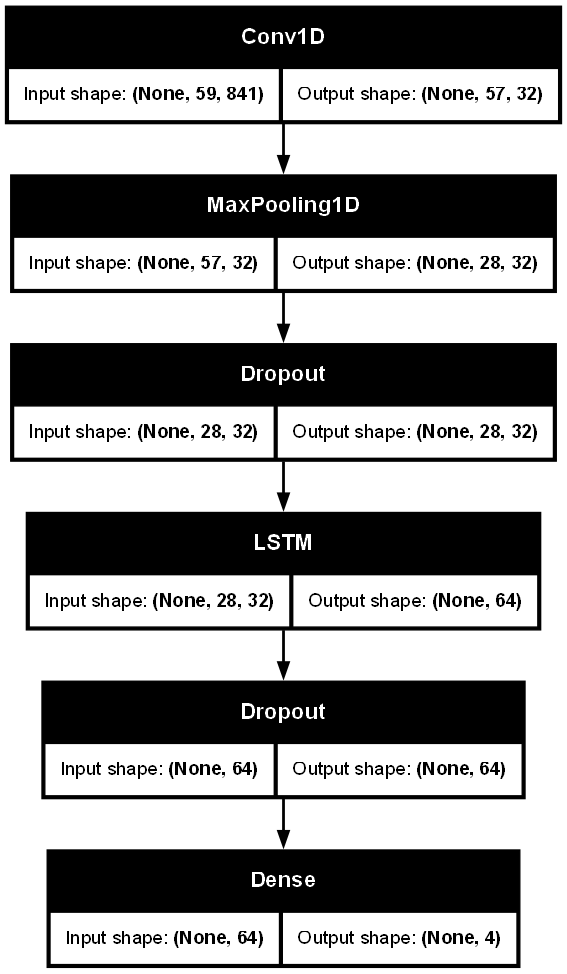

In [212]:
# Afficher l'architecture du modèle CNN-LSTM
plot_model(cnn_lstm_model, show_shapes=True, show_layer_names=False,dpi=100)

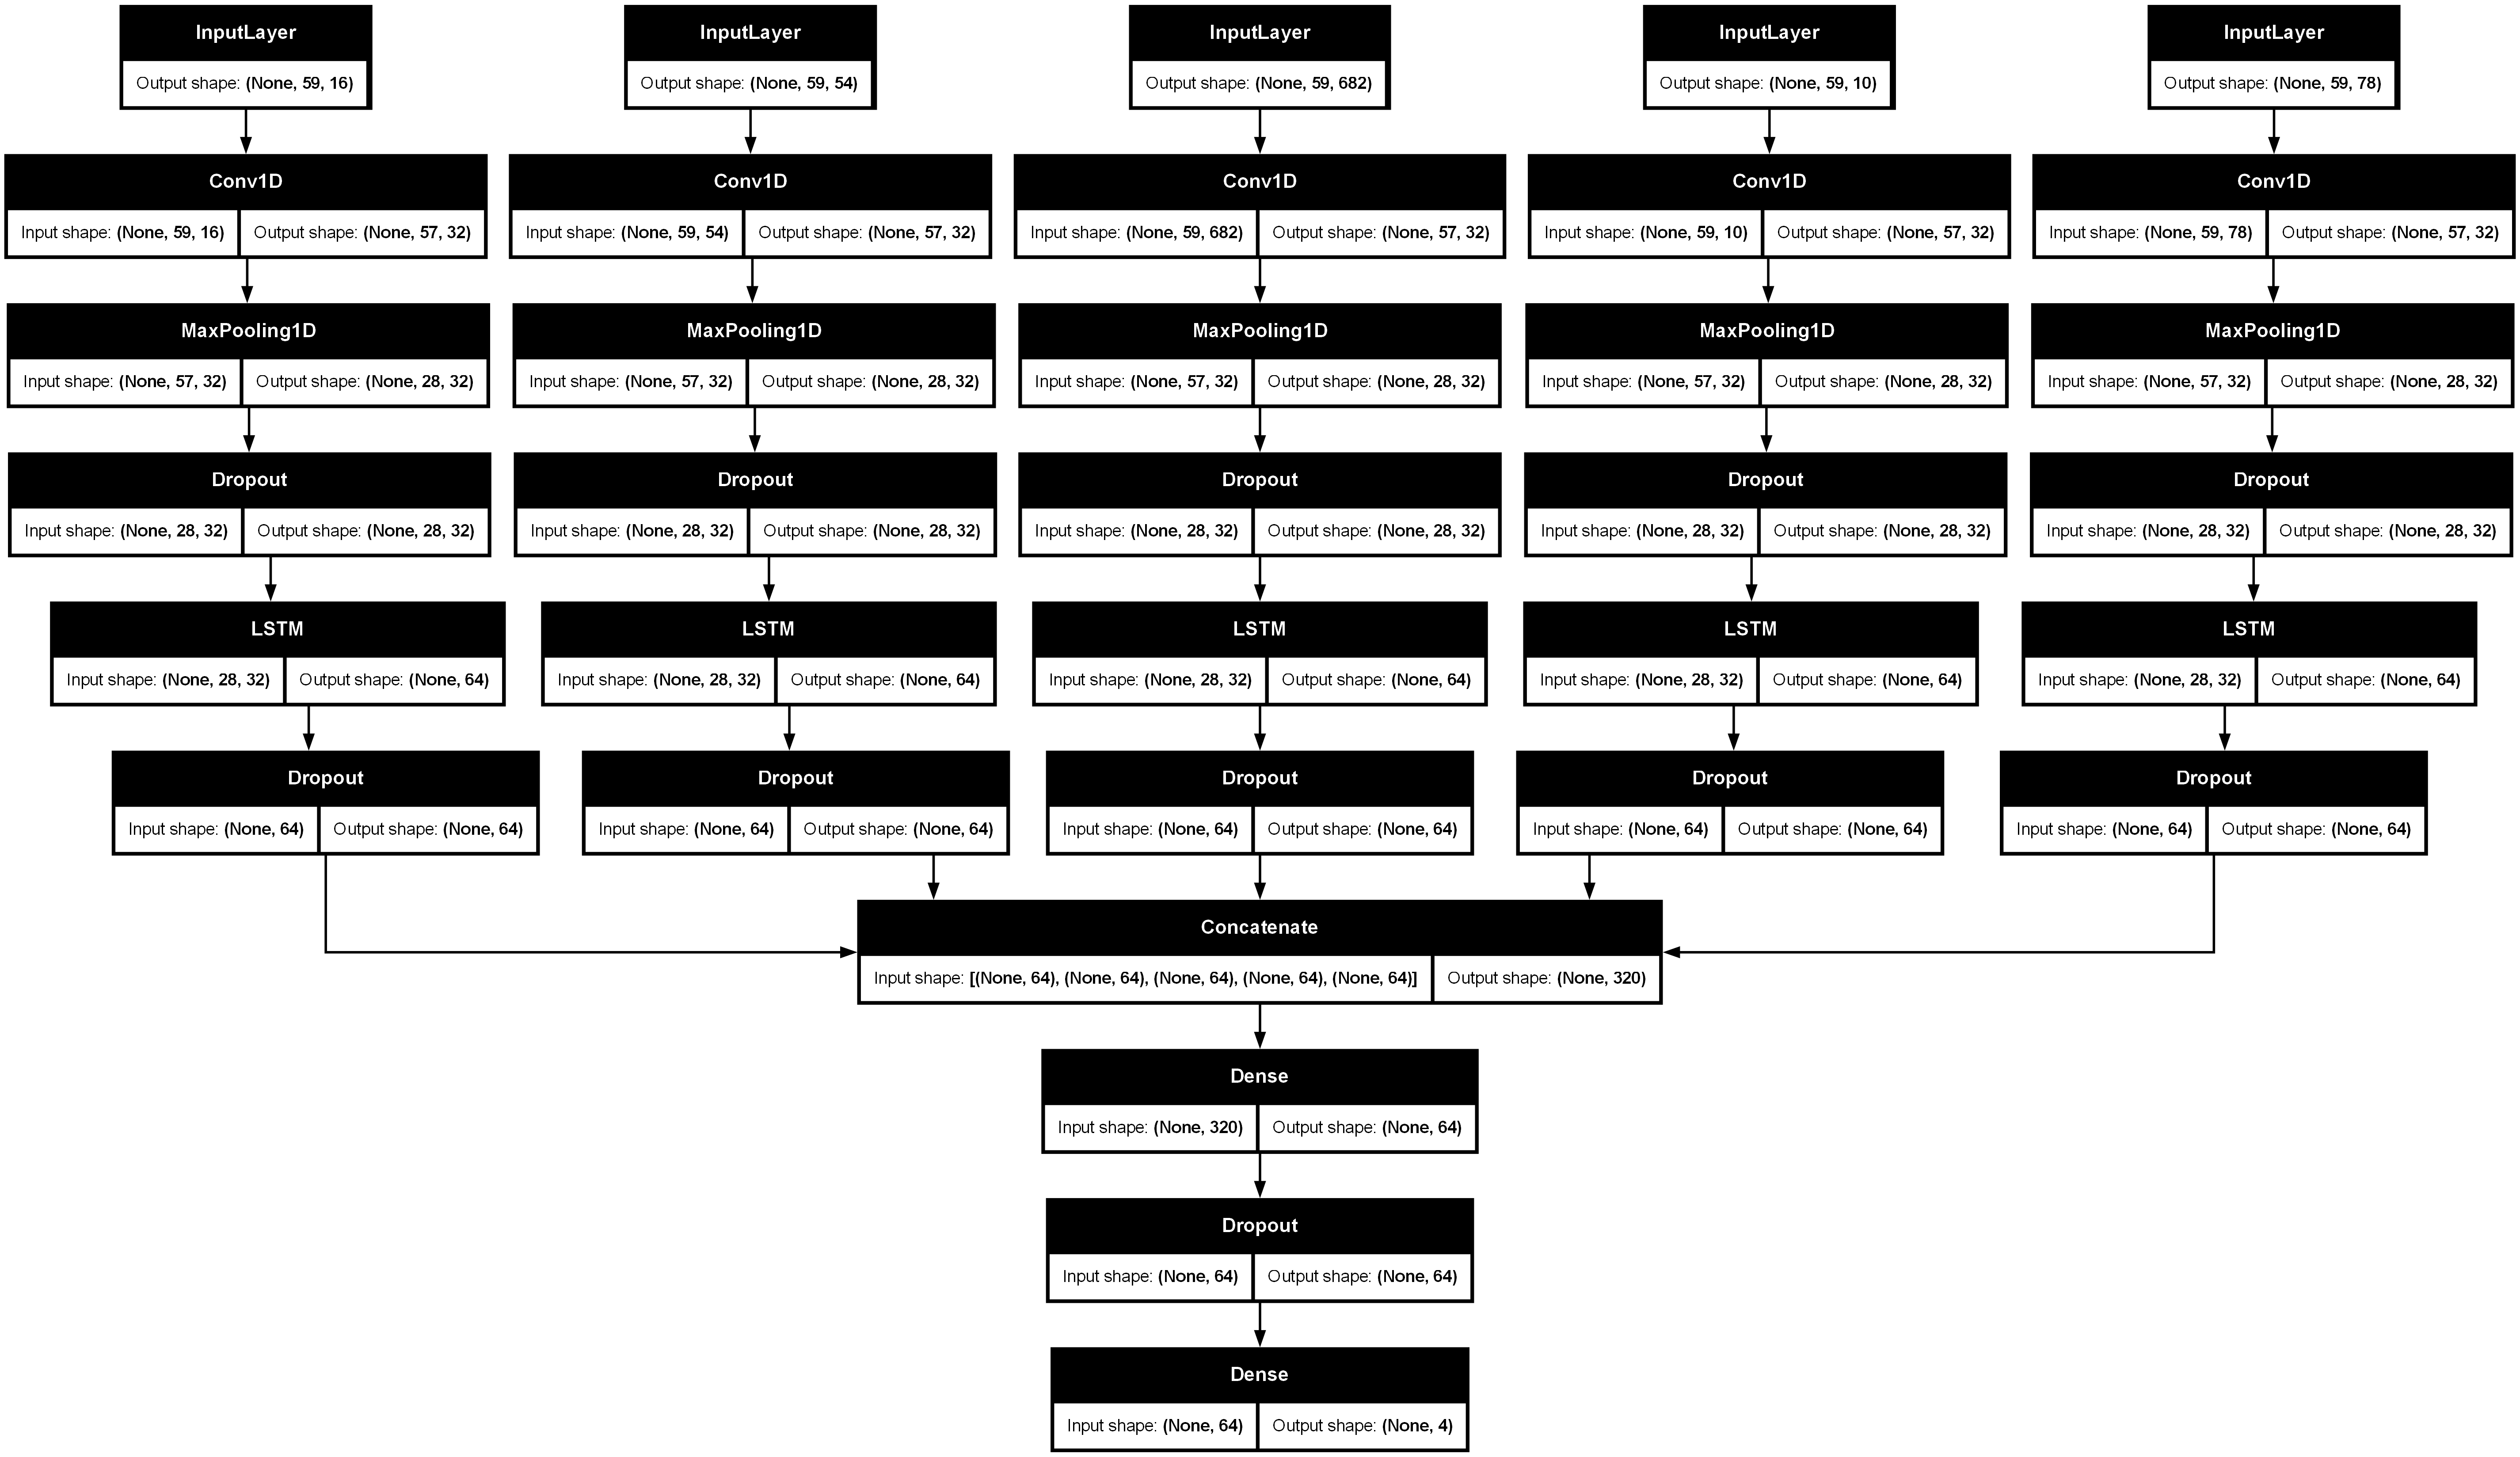

In [76]:
# Afficher l'architecture du modèle CNN-LSTM-MULTIMODAL
plot_model(cnn_lstm_multimodal_model, show_shapes=True, show_layer_names=False)

Pour le choix des l'architectures, les CNN sont particulièrement adaptés pour extraire des caractéristiques locales et spatiales à partir des données, en l'occurrence des signaux comme ceux provenant de capteurs (EMG, IMU, IPS, COP, MOCAP), grâce aux couches de convolution et de pooling. 

L'ajout de couches LSTM, qui sont des réseaux récurrents capables de capturer des dépendances à long terme dans les séquences temporelles, permet de modéliser les relations temporelles et dynamiques complexes entre les différentes observations. 

Cette combinaison de CNN pour l'extraction de caractéristiques locales et de LSTM pour la modélisation des relations temporelles est particulièrement pertinente pour des données où chaque type de signal peut contenir des informations pertinentes à différents niveaux temporels et contextuels.

Dans le cas du modèle multimodal, chaque type de donnée (EMG, IMU, IPS, COP, MOCAP) est traité indépendamment à l’aide de sous-modèles CNN-LSTM, ce qui permet une extraction et une gestion efficaces des caractéristiques propres à chaque modalité. 

Ces sous-modèles sont ensuite fusionnés pour former une représentation intégrée des données, permettant au réseau de capturer les interactions entre les différents types de capteurs et d’améliorer la performance de la prédiction. 

Cette approche multimodale est essentielle pour les applications complexes où plusieurs sources de données doivent être combinées pour une meilleure compréhension du phénomène observé. 

Enfin, l'utilisation de la régularisation par Dropout aide à éviter le surapprentissage, garantissant une meilleure généralisation du modèle.

### 6. Optimisation des hyperparamètres pour les modèles Normal Split

Nous utilisons GridSearchCV pour optimiser nos modèles :
- Test de différentes tailles de batch (16, 32)
- Variation du nombre d'époques (5, 10)
- Validation croisée pour une évaluation robuste

Cette étape nous permet d'identifier les meilleurs paramètres pour chaque architecture.

In [104]:
# Création du modèle Keras à l'aide du wrapper KerasClassifier
# 'build_fn' spécifie la fonction de création du modèle, 'input_shape' définit la forme des données d'entrée,
# 'epochs' et 'batch_size' sont les paramètres d'entraînement.
model = KerasClassifier(build_fn=create_cnn_lstm_model, input_shape=X_train.shape[1:], epochs=10, batch_size=32, verbose=0)

# Définition de la grille de paramètres à tester lors de la recherche
# 'batch_size' et 'epochs' sont les hyperparamètres que nous allons tester pour trouver les meilleures valeurs
param_grid = {
    'batch_size': [16, 32],  # Tester deux tailles de batch différentes
    'epochs': [5, 10]        # Tester deux nombres d'époques différents
}

# Initialisation de GridSearchCV, qui va tester toutes les combinaisons possibles des hyperparamètres spécifiés
# 'estimator' est le modèle à optimiser, 'param_grid' contient les hyperparamètres à tester
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# Lancement de la recherche sur la grille en utilisant les données d'entraînement X_train et y_train
grid_search.fit(X_train, y_train)

# Affichage des meilleurs paramètres trouvés par GridSearchCV
print(f"Meilleurs paramètres: {grid_search.best_params_}")

# Affichage du meilleur score (moyenne des scores de validation croisée) associé à la combinaison optimale des paramètres
print(f"Meilleur score: {grid_search.best_score_}")


C:\Users\floda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\floda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Meilleurs paramètres: {'batch_size': 32, 'epochs': 10}
Meilleur score: 0.8460243468440952


Une fois les meilleurs paramètres identifiés les modèles sont alors entraînés.

In [105]:
# Entraîner le modèle CNN-LSTM avec les meilleurs paramètres
history_cnn_lstm_normal = cnn_lstm_model.fit(X_train, y_train, epochs=grid_search.best_params_['epochs'], batch_size=grid_search.best_params_['batch_size'], validation_data=(X_test, y_test))

# Évaluer les performances sur l'ensemble de test
score_cnn_lstm_normal = cnn_lstm_model.evaluate(X_test, y_test)
print(f"Score du modèle CNN-LSTM : {score_cnn_lstm_normal}")

# Entraîner le modèle CNN-LSTM-MULTIMODAL avec les meilleurs paramètres
history_cnn_lstm_multimodal_normal = cnn_lstm_multimodal_model.fit(
    [X_emg_train, X_imu_train, X_ips_train,X_cop_train,X_mocap_train], y_train,
    batch_size=grid_search.best_params_['batch_size'],
    epochs=grid_search.best_params_['epochs'],
    validation_data=([X_emg_test, X_imu_test, X_ips_test,X_cop_test,X_mocap_test], y_test)
)

# Évaluer les performances sur l'ensemble de test
score_cnn_lstm_multimodal_normal = cnn_lstm_multimodal_model.evaluate([X_emg_train, X_imu_train, X_ips_train,X_cop_train,X_mocap_train], y_train)
print(f"Score du modèle CNN-LSTM : {score_cnn_lstm_multimodal_normal}")


Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3935 - loss: 1.2817 - val_accuracy: 0.6199 - val_loss: 0.9003
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6513 - loss: 0.8456 - val_accuracy: 0.7519 - val_loss: 0.6848
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7622 - loss: 0.6140 - val_accuracy: 0.7999 - val_loss: 0.5452
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8462 - loss: 0.4195 - val_accuracy: 0.7714 - val_loss: 0.5978
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8096 - loss: 0.4943 - val_accuracy: 0.8193 - val_loss: 0.5429
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8756 - loss: 0.3539 - val_accuracy: 0.8741 - val_loss: 0.4047
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9173 - loss: 0.2368 - val_accuracy: 0.8763 - val_loss: 0.3881
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9378 - loss: 0.1748 - val_accuracy: 0

Une fois la phase d'entrainement réalisé nous faisons des prédictions sur les ensembles de test afin d'avoir des données pour, plus tard, évaluer nos modèles

In [107]:
# ------------------------ CNN-LSTM ------------------------

# Prédictions sur l'ensemble de test pour le modèle CNN-LSTM
# Le modèle prédit les probabilités pour chaque classe. 
# np.argmax est utilisé pour obtenir la classe ayant la probabilité maximale.
y_pred_cnn_lstm_normal = np.argmax(cnn_lstm_model.predict(X_test), axis=-1)

# Transformation du OneHotEncoder en labels de classe pour y_test
# y_test est un vecteur OneHot encodé, nous utilisons np.argmax pour récupérer les indices des classes.
y_test_labels_normal = np.argmax(y_test, axis=-1)

# Générer un rapport de classification pour CNN-LSTM
# classification_report génère un rapport détaillé contenant la précision, le rappel, le score F1 pour chaque classe.
# Il prend les labels réels et les prédictions, et le 'target_names' permet de nommer les classes (label_encoder.classes_).
report_cnn_lstm_normal = classification_report(y_test_labels_normal, y_pred_cnn_lstm_normal, 
                                              target_names=label_encoder.classes_, output_dict=True)

# Matrice de confusion pour CNN-LSTM
# La matrice de confusion montre les prédictions correctes et incorrectes sous forme de tableau,
# permettant d'analyser les performances pour chaque classe.
conf_matrix_cnn_lstm_normal = confusion_matrix(y_test_labels_normal, y_pred_cnn_lstm_normal)


# ------------------------ Multimodal CNN-LSTM ------------------------

# Prédictions sur l'ensemble de test pour le modèle multimodal CNN-LSTM
# Le modèle multimodal prend plusieurs sources d'entrées : EMG, IMU, IPS, COP, et MOCAP.
# Nous utilisons predict pour obtenir les prédictions du modèle multimodal.
predictions_multimodal_normal = cnn_lstm_multimodal_model.predict([X_emg_test, X_imu_test, X_ips_test, X_cop_test, X_mocap_test])

# On utilise np.argmax pour obtenir la classe prédite (la classe avec la probabilité maximale).
y_pred_multimodal_normal = np.argmax(predictions_multimodal_normal, axis=-1)

# Générer un rapport de classification pour le modèle multimodal CNN-LSTM
# Un rapport détaillé de la classification est généré pour évaluer la performance du modèle multimodal
report_multimodal_normal = classification_report(y_test_labels_normal, y_pred_multimodal_normal, 
                                                target_names=label_encoder.classes_, output_dict=True)

# Matrice de confusion pour le modèle multimodal CNN-LSTM
# La matrice de confusion permet de visualiser les erreurs du modèle multimodal sur les prédictions.
conf_matrix_multimodal_normal = confusion_matrix(y_test_labels_normal, y_pred_multimodal_normal)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


C:\Users\floda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['emg_input', 'imu_input', 'ips_input', 'cop_input', 'mocap_input']. Received: the structure of inputs=('*', '*', '*', '*', '*')
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


### 7. Création des données d'entrainement et de test pour le logo split

Nous allons maintenant préparer nos données pour l'entraînement des modèles utilisant les données de logo split.

Nous commençons par créer un DataFrame combiné regroupant toutes les données des différents capteurs. 

Contrairement au split normal, nous devons ici préserver l'information sur les patients pour assurer une séparation correcte des données.


In [192]:
# Création d'un DataFrame vide pour stocker les données combinées
combined_df = pd.DataFrame()

# Boucle sur chaque type de capteur dans la liste SENSORS_TYPE
for sensor in SENSORS_TYPE:
    
    # Lecture des données depuis le fichier CSV correspondant à ce capteur dans le répertoire 'logo_split'
    data = pd.read_csv(f"logo_split/{sensor}.csv")
    
    # Si la colonne 'label' existe déjà dans combined_df, elle est supprimée pour éviter les doublons
    # 'errors="ignore"' évite de lever une erreur si la colonne 'label' n'existe pas
    combined_df.drop(columns=['label'], inplace=True, errors='ignore')
    
    # Si la colonne 'patient' existe déjà dans combined_df, elle est supprimée pour éviter les doublons
    # 'errors="ignore"' évite de lever une erreur si la colonne 'patient' n'existe pas
    combined_df.drop(columns=['patient'], inplace=True, errors='ignore')
    
    # Concaténation des nouvelles données (data) au DataFrame combiné (combined_df)
    # Les nouvelles données sont ajoutées horizontalement (axis=1), donc les colonnes de data sont ajoutées à combined_df
    combined_df = pd.concat([combined_df, data], axis=1)


Nous identifions les 25 patients uniques dans notre jeu de données et les séparons en deux groupes :
- 20 patients pour l'entraînement
- 5 patients pour le test

Cette approche "Leave-One-Group-Out" (LOGO) nous permet d’évaluer la généralisation inter-sujets.

In [193]:
# Identifiez les 25 patients uniques
patients = combined_df['patient'].unique()

# Diviser les patients en ensembles d'entraînement et de test
train_patients = patients[:20]  # 20 premiers patients pour l'entraînement
test_patients = patients[-5:]   # 5 derniers patients pour le test

In [194]:
# Filtrer les données en fonction des patients
train_data = combined_df[combined_df['patient'].isin(train_patients)]
test_data = combined_df[combined_df['patient'].isin(test_patients)]

Nous appliquons notre fonction de création de fenêtres sur les données séparées par patients. 

Cette étape est cruciale car elle maintient la séparation stricte entre les patients d'entraînement et de test, évitant toute fuite de données.

In [195]:
# Créer les fenêtres pour l'entraînement et le test
X_train, y_train = create_windows(train_data, window_size, step_size)
X_test, y_test = create_windows(test_data, window_size, step_size)


Ensuite, nous normalison les données. La normalisation des données est effectuée séparément pour les ensembles d'entraînement et de test. 

Cette approche garantit qu'aucune information des patients de test n'influence la normalisation des données d'entraînement.

In [196]:
# Normalisation des données sur chaque fenêtre
scaler = StandardScaler()

# Appliquer la normalisation sur chaque fenêtre (chaque "fenêtre" dans X)
X_train = np.array([scaler.fit_transform(window) for window in X_train])
X_test = np.array([scaler.transform(window) for window in X_test])  # Utiliser le même scaler pour le test

Pour chaque type de capteur (EMG, IMU, IPS, COP, MOCAP), nous séparons les données selon les patients d'entraînement et de test, créons les fenêtres temporelles appropriées et normalisons les données tout en préservant la séparation par patient

In [197]:
def create_train_test_for_submodel(data_path, train_data, test_data):
    # Charger les données depuis un fichier CSV
    df = pd.read_csv(data_path)
    
    # Sélectionner les lignes où la colonne 'patient' est dans les patients d'entraînement
    train = df[df['patient'].isin(train_data)]
    
    # Sélectionner les lignes où la colonne 'patient' est dans les patients de test
    test = df[df['patient'].isin(test_data)]
    
    return train, test

def create_windows_train_test_for_submodel(train, test, window_size=60, step_size=60):
    # Appliquer la segmentation en fenêtres sur les données d'entraînement
    train, _ = create_windows(train, window_size, step_size)
    
    # Appliquer la segmentation en fenêtres sur les données de test
    test, _ = create_windows(test, window_size, step_size)
    
    return train, test

def scale_train_test_for_submodel (windows) :
    # Créer une instance de StandardScaler pour normaliser les données
    scaler = StandardScaler()
    
    # Normaliser les fenêtres d'entraînement
    scaled_train = np.array([scaler.fit_transform(window) for window in windows['train']])
    
    # Normaliser les fenêtres de test en utilisant les paramètres du scaler entraîné sur les données d'entraînement
    scaled_test = np.array([scaler.transform(window) for window in windows['test']])
    
    return scaled_train, scaled_test

# Chargement des données pour chaque modalité (IPS, EMG, IMU, COP, MOCAP) pour les patients d'entraînement et de test
train_ips,test_ips = create_train_test_for_submodel ("logo_split/ips.csv",train_patients,test_patients)
train_emg ,test_emg = create_train_test_for_submodel ("logo_split/emg.csv",train_patients,test_patients)
train_imu,test_imu = create_train_test_for_submodel ("logo_split/imu.csv",train_patients,test_patients)
train_cop , test_cop = create_train_test_for_submodel ("logo_split/cop.csv",train_patients,test_patients)
train_mocap ,test_mocap = create_train_test_for_submodel ("logo_split/mocap.csv",train_patients,test_patients)

# Segmentation en fenêtres pour chaque modalité
X_ips_train, X_ips_test = create_windows_train_test_for_submodel (train_ips,test_ips)
X_emg_train, X_emg_test = create_windows_train_test_for_submodel (train_emg,test_emg)
X_imu_train, X_imu_test = create_windows_train_test_for_submodel (train_imu,test_imu)
X_cop_train, X_cop_test = create_windows_train_test_for_submodel (train_cop,test_cop)
X_mocap_train, X_mocap_test = create_windows_train_test_for_submodel (train_mocap,test_mocap)

# Normalisation des données segmentées pour chaque modalité
X_emg_train, X_emg_test = scale_train_test_for_submodel ({'train' : X_emg_train,'test':X_emg_test})
X_imu_train, X_imu_test = scale_train_test_for_submodel ({'train' : X_imu_train,'test':X_imu_test})
X_cop_train, X_cop_test = scale_train_test_for_submodel ({'train' : X_cop_train,'test':X_cop_test})
X_mocap_train, X_mocap_test = scale_train_test_for_submodel ({'train' : X_mocap_train,'test':X_mocap_test})

# Affichage des dimensions des données pour vérifier la forme des ensembles de données après la segmentation et la normalisation
print(f'X_ips_train shape: {X_ips_train.shape}, X_ips_test shape: {X_ips_test.shape}')
print(f'X_emg_train shape: {X_emg_train.shape}, X_emg_test shape: {X_emg_test.shape}')
print(f'X_imu_train shape: {X_imu_train.shape}, X_imu_test shape: {X_imu_test.shape}')
print(f'X_cop_train shape: {X_cop_train.shape}, X_cop_test shape: {X_cop_test.shape}')
print(f'X_mocap_train shape: {X_mocap_train.shape}, X_mocap_test shape: {X_mocap_test.shape}')


X_ips_train shape: (5608, 59, 683), X_ips_test shape: (1058, 59, 683)
X_emg_train shape: (5622, 59, 17), X_emg_test shape: (1043, 59, 17)
X_imu_train shape: (5623, 59, 55), X_imu_test shape: (1042, 59, 55)
X_cop_train shape: (5672, 59, 11), X_cop_test shape: (994, 59, 11)
X_mocap_train shape: (5623, 59, 79), X_mocap_test shape: (1042, 59, 79)


In [199]:
# Encodage des labels en one-hot pour les données test et train
label_encoder = LabelEncoder()
y_train = to_categorical(label_encoder.fit_transform(y_train), num_classes=4)
y_test = to_categorical(label_encoder.transform(y_test), num_classes=4)

# Affichage des dimensions des données segmentées et normalisées
print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}, y_test shape: {y_test.shape}')

X_train shape: (5623, 59, 841), X_test shape: (1042, 59, 841)
y_train shape: (5623, 4), y_test shape: (1042, 4)


# 8. Création et compilation des modèles pour le LOGO split

Nous réutilisons les architectures développées précédemment, mais en les adaptant aux spécificités du split LOGO.

In [200]:
# Créer le modèle CNN-LSTM-LOGO
cnn_lstm_model = create_cnn_lstm_model(X_train.shape[1:3])

# Créer le modèle CNN-LSTM-MULTIMODAL-LOGO
cnn_lstm_multimodal_model = create_cnn_lstm_multimodal_model(input_shape = [
    X_emg_train.shape[1:3],
    X_imu_train.shape[1:3],
    X_ips_train.shape[1:3],
    X_cop_train.shape[1:3],
    X_mocap_train.shape[1:3],
])

C:\Users\floda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


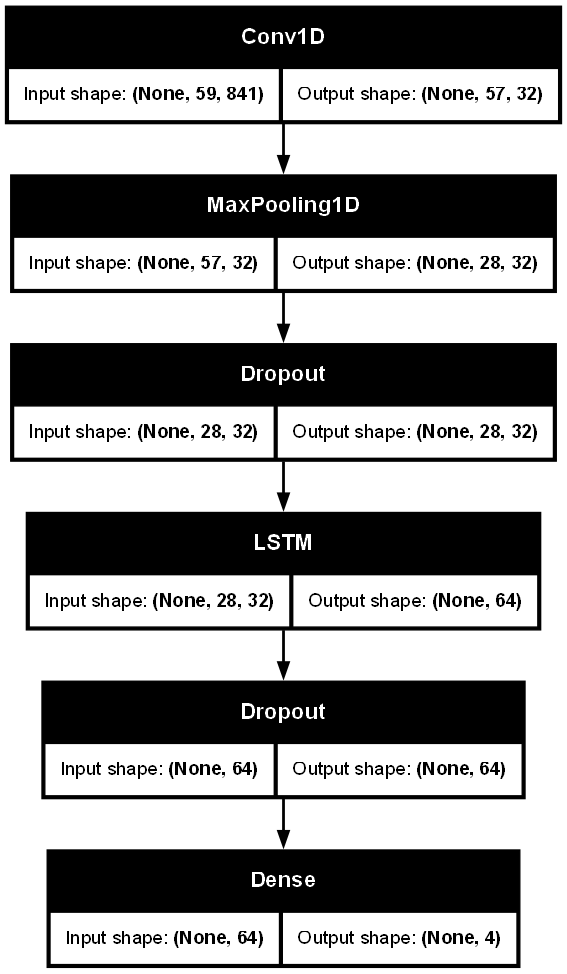

In [201]:
# Afficher l'architecture du modèle CNN-LSTM-LOGO
plot_model(cnn_lstm_model, show_shapes=True, show_layer_names=False,dpi=100)

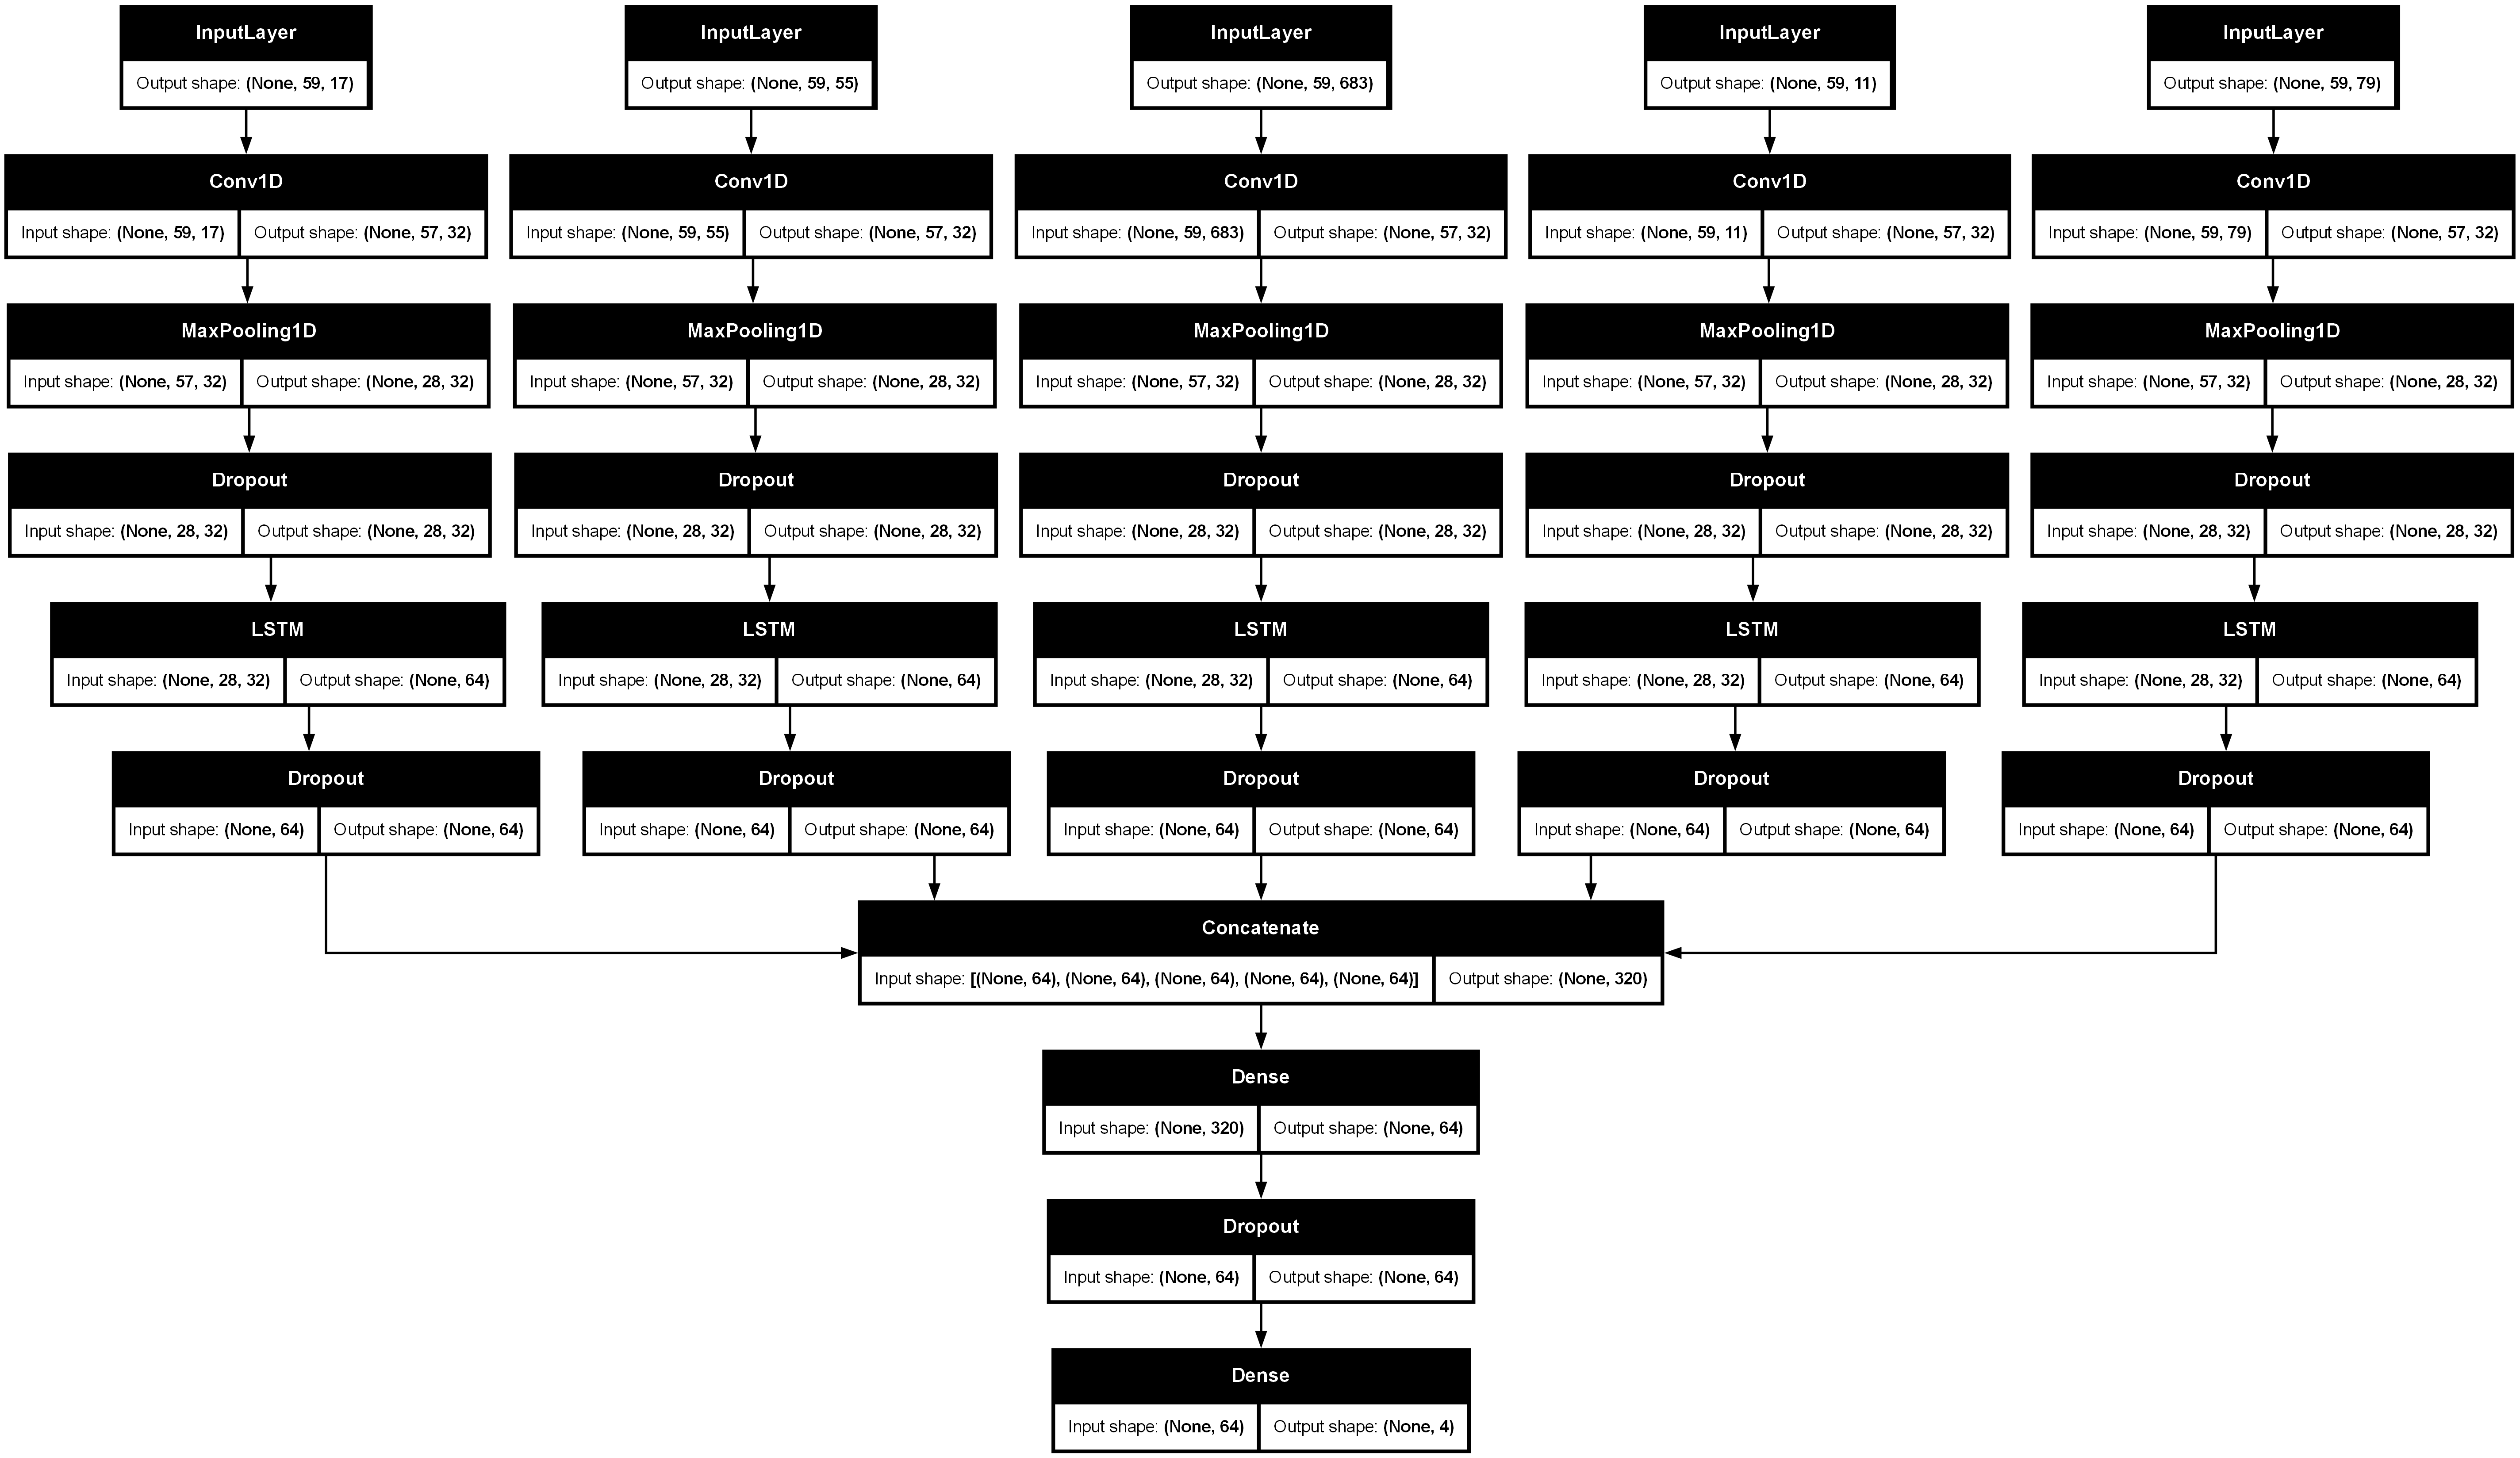

In [202]:
# Afficher l'architecture du modèle CNN-LSTM-MULTIMODAL-LOGO
plot_model(cnn_lstm_multimodal_model, show_shapes=True, show_layer_names=False)

Pour assurer la cohérence de notre modèle multimodal, nous alignons les dimensions des données de chaque modalité.

In [204]:
# Calcul des tailles minimales pour l'entraînement et le test
min_value_train = min(X_emg_train.shape[0], X_imu_train.shape[0], X_ips_train.shape[0], X_cop_train.shape[0], X_mocap_train.shape[0])
min_value_test = min(X_emg_test.shape[0], X_imu_test.shape[0], X_ips_test.shape[0], X_cop_test.shape[0], X_mocap_test.shape[0])

# Découper les données de train pour que toutes les modalités aient le même nombre d'exemples
X_emg_train = X_emg_train[:min_value_train]
X_imu_train = X_imu_train[:min_value_train]
X_ips_train = X_ips_train[:min_value_train]
X_cop_train = X_cop_train[:min_value_train]
X_mocap_train = X_mocap_train[:min_value_train]

# Découper les données de test pour que toutes les modalités aient le même nombre d'exemples
X_emg_test = X_emg_test[:min_value_test]
X_imu_test = X_imu_test[:min_value_test]
X_ips_test = X_ips_test[:min_value_test]
X_cop_test = X_cop_test[:min_value_test]
X_mocap_test = X_mocap_test[:min_value_test]

# Découper les données des labels pour que toutes les modalités aient le même nombre d'exemples
y_train = y_train[:min_value_train]
y_test = y_test[:min_value_test]

Nous appliquons la même approche d'optimisation que précédemment, mais cette fois en respectant la structure du split LOGO.

In [205]:
# Encapsuler le modèle dans KerasClassifier pour l'utiliser avec GridSearchCV
model = KerasClassifier(build_fn=create_cnn_lstm_model, input_shape=X_train.shape[1:], epochs=10, batch_size=32, verbose=0)

# Définir la grille des hyperparamètres à tester
param_grid = {
    'batch_size': [16, 32],
    'epochs': [5, 10]
}

# Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_search.fit(X_train, y_train)


C:\Users\floda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\floda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


GridSearchCV(cv=3,
             estimator=KerasClassifier(batch_size=32, build_fn=<function create_cnn_lstm_model at 0x000001F18DBE44A0>, epochs=10, input_shape=(59, 841), verbose=0),
             n_jobs=-1, param_grid={'batch_size': [16, 32], 'epochs': [5, 10]})

L'entraînement des modèles est alors réalisé avec les meilleurs hyperparamètres identifiés.

In [220]:
# Entraîner le modèle CNN-LSTM-LOGO avec les meilleurs paramètres
history_cnn_lstm_logo = cnn_lstm_model.fit(X_train, y_train, epochs=grid_search.best_params_['epochs'], batch_size=grid_search.best_params_['batch_size'], validation_data=(X_test, y_test))

# Évaluer les performances sur l'ensemble de test
score_cnn_lstm_logo = cnn_lstm_model.evaluate(X_test, y_test)
print(f"Score du modèle CNN-LSTM : {score_cnn_lstm_logo}")

# Entraîner le modèle CNN-LSTM-MULTIMODAL-LOGO avec les meilleurs paramètres
history_cnn_lstm_multimodal_logo = cnn_lstm_multimodal_model.fit(
    [X_emg_train, X_imu_train, X_ips_train,X_cop_train,X_mocap_train], y_train,
    batch_size=grid_search.best_params_['batch_size'],
    epochs=grid_search.best_params_['epochs'],
    validation_data=([X_emg_test, X_imu_test, X_ips_test,X_cop_test,X_mocap_test], y_test)
)

# Évaluer les performances sur l'ensemble de test
score_cnn_lstm_multimodal_logo = cnn_lstm_multimodal_model.evaluate([X_emg_train, X_imu_train, X_ips_train,X_cop_train,X_mocap_train], y_train)
print(f"Score du modèle CNN-LSTM : {score_cnn_lstm_multimodal_logo}")


Epoch 1/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9259 - loss: 0.2017 - val_accuracy: 0.2686 - val_loss: 18.7880
Epoch 2/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9432 - loss: 0.1649 - val_accuracy: 0.2143 - val_loss: 12.8194
Epoch 3/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9472 - loss: 0.1680 - val_accuracy: 0.3229 - val_loss: 7.9065
Epoch 4/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9584 - loss: 0.1213 - val_accuracy: 0.3742 - val_loss: 5.3173
Epoch 5/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9577 - loss: 0.1268 - val_accuracy: 0.3612 - val_loss: 6.9687
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3339 - loss: 7.9342
Score du modèle CNN-LSTM : [6.968696117401123, 0.3611670136451721]
Epoch 1/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9842 - loss: 0.0524 - val_accuracy: 0.7344 - val_loss: 0.7221
Epoch 2/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9862 - loss: 0.0361 - val_acc

Une fois encore nous faisons des prédictions sur les ensembles de test afin d'avoir des données pour, plus tard, évaluer nos modèles

In [221]:
# ------------------------ CNN-LSTM ------------------------

# Prédictions sur l'ensemble de test pour le modèle CNN-LSTM
# Le modèle prédit les probabilités pour chaque classe. 
# np.argmax est utilisé pour obtenir la classe ayant la probabilité maximale.
y_pred_cnn_lstm_logo = np.argmax(cnn_lstm_model.predict(X_test), axis=-1)

# Transformation du OneHotEncoder en labels de classe pour y_test
# y_test est un vecteur OneHot encodé, nous utilisons np.argmax pour récupérer les indices des classes.
y_test_labels_logo = np.argmax(y_test, axis=-1)

# Générer un rapport de classification pour CNN-LSTM
# classification_report génère un rapport détaillé contenant la précision, le rappel, le score F1 pour chaque classe.
# Il prend les labels réels et les prédictions, et le 'target_names' permet de nommer les classes (label_encoder.classes_).
report_cnn_lstm_logo = classification_report(y_test_labels_logo, y_pred_cnn_lstm_logo, 
                                              target_names=label_encoder.classes_, output_dict=True)

# Matrice de confusion pour CNN-LSTM
# La matrice de confusion montre les prédictions correctes et incorrectes sous forme de tableau,
# permettant d'analyser les performances pour chaque classe.
conf_matrix_cnn_lstm_logo = confusion_matrix(y_test_labels_logo, y_pred_cnn_lstm_logo)


# ------------------------ Multimodal CNN-LSTM ------------------------

# Prédictions sur l'ensemble de test pour le modèle multimodal CNN-LSTM
# Le modèle multimodal prend plusieurs sources d'entrées : EMG, IMU, IPS, COP, et MOCAP.
# Nous utilisons predict pour obtenir les prédictions du modèle multimodal.
predictions_multimodal_logo = cnn_lstm_multimodal_model.predict([X_emg_test, X_imu_test, X_ips_test, X_cop_test, X_mocap_test])

# On utilise np.argmax pour obtenir la classe prédite (la classe avec la probabilité maximale).
y_pred_multimodal_logo = np.argmax(predictions_multimodal_logo, axis=-1)

# Générer un rapport de classification pour le modèle multimodal CNN-LSTM
# Un rapport détaillé de la classification est généré pour évaluer la performance du modèle multimodal
report_multimodal_logo = classification_report(y_test_labels_logo, y_pred_multimodal_logo, 
                                                target_names=label_encoder.classes_, output_dict=True)

# Matrice de confusion pour le modèle multimodal CNN-LSTM
# La matrice de confusion permet de visualiser les erreurs du modèle multimodal sur les prédictions.
conf_matrix_multimodal_logo = confusion_matrix(y_test_labels_logo, y_pred_multimodal_logo)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


# 9. Analyse détaillée des résultats

Nous allons maintenant analyser chaque modèle pour déterminer lequel à possède les meilleures performances

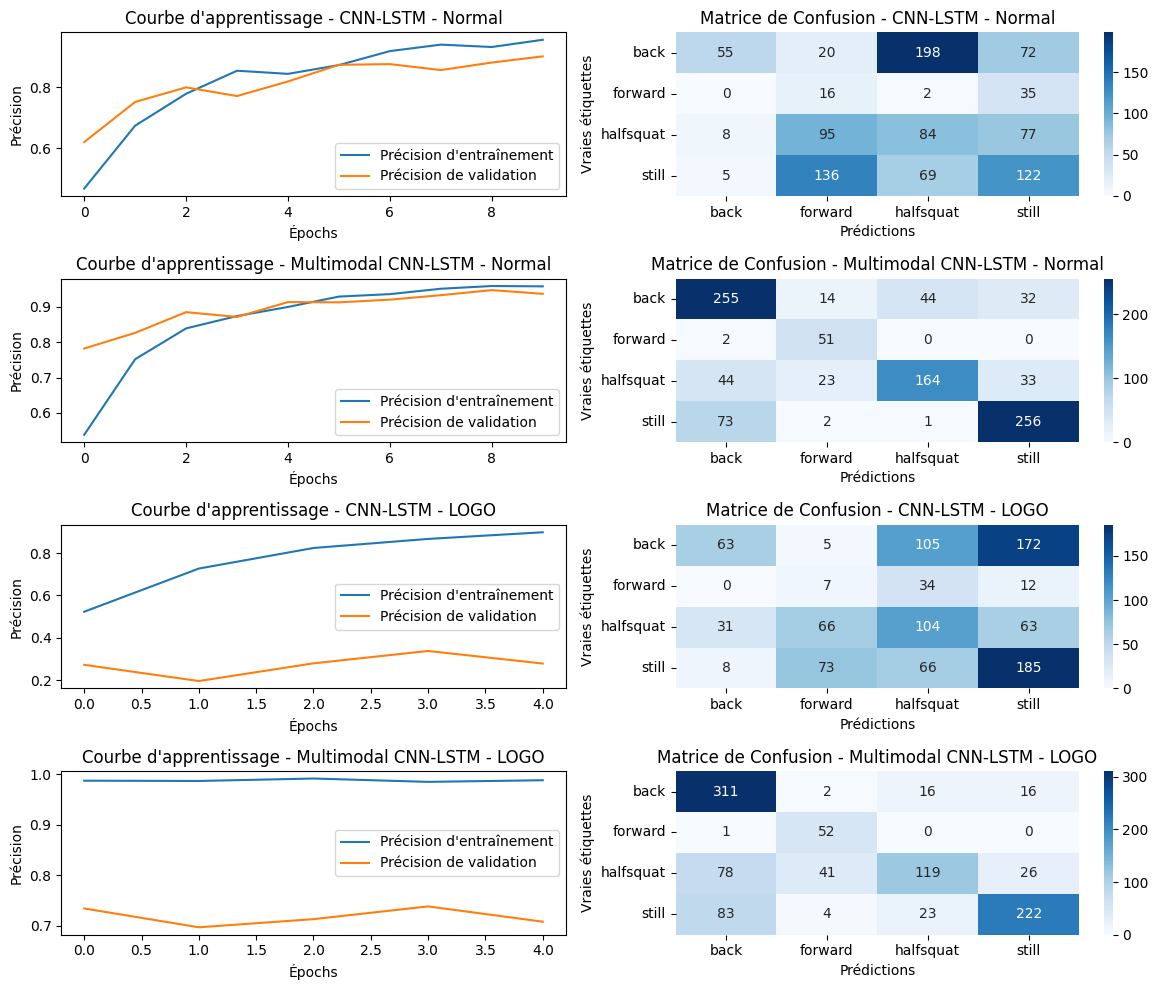

In [222]:
# ------------------------ Plotting Results ------------------------

# Courbes d'apprentissage pour les deux modèles
plt.figure(figsize=(12, 10))

# Courbes d'apprentissage - CNN-LSTM
plt.subplot(4, 2, 1)
plt.plot(history_cnn_lstm_normal.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history_cnn_lstm_normal.history['val_accuracy'], label='Précision de validation')
plt.title('Courbe d\'apprentissage - CNN-LSTM - Normal')
plt.xlabel('Épochs')
plt.ylabel('Précision')
plt.legend()

# Matrice de confusion - CNN-LSTM
plt.subplot(4, 2, 2)
sns.heatmap(conf_matrix_cnn_lstm_normal, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de Confusion - CNN-LSTM - Normal')

# Courbes d'apprentissage - Multimodal CNN-LSTM
plt.subplot(4, 2, 3)
plt.plot(history_cnn_lstm_multimodal_normal.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history_cnn_lstm_multimodal_normal.history['val_accuracy'], label='Précision de validation')
plt.title('Courbe d\'apprentissage - Multimodal CNN-LSTM - Normal')
plt.xlabel('Épochs')
plt.ylabel('Précision')
plt.legend()

# Matrice de confusion - Multimodal CNN-LSTM
plt.subplot(4, 2, 4)
sns.heatmap(conf_matrix_multimodal_normal, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de Confusion - Multimodal CNN-LSTM - Normal')

# ------------------------ Plotting Results ------------------------

# Courbes d'apprentissage - CNN-LSTM
plt.subplot(4, 2, 5)
plt.plot(history_cnn_lstm.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history_cnn_lstm.history['val_accuracy'], label='Précision de validation')
plt.title('Courbe d\'apprentissage - CNN-LSTM - LOGO')
plt.xlabel('Épochs')
plt.ylabel('Précision')
plt.legend()

# Matrice de confusion - CNN-LSTM
plt.subplot(4, 2, 6)
sns.heatmap(conf_matrix_cnn_lstm_logo, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de Confusion - CNN-LSTM - LOGO')

# Courbes d'apprentissage - Multimodal CNN-LSTM
plt.subplot(4, 2, 7)
plt.plot(history_cnn_lstm_multimodal_logo.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history_cnn_lstm_multimodal_logo.history['val_accuracy'], label='Précision de validation')
plt.title('Courbe d\'apprentissage - Multimodal CNN-LSTM - LOGO')
plt.xlabel('Épochs')
plt.ylabel('Précision')
plt.legend()

# Matrice de confusion - Multimodal CNN-LSTM
plt.subplot(4, 2, 8)
sns.heatmap(conf_matrix_multimodal_logo, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de Confusion - Multimodal CNN-LSTM - LOGO')

# Ajustement pour éviter le chevauchement des titres et des étiquettes
plt.tight_layout()
plt.show()

Les courbes d'apprentissage montrent l'évolution de la précision en fonction des époques pour les phases d'entraînement et de validation.

- Normal split

    - Unifiée : Nous observons une augmentation régulière de la précision d'entraînement et de validation, atteignant des valeurs proches après 10 époques. Cela indique que ce modèle est capable d'apprendre efficacement et de généraliser sur l'ensemble de validation, avec un faible risque de surapprentissage.

    - Multimodale :  Les performances sont nettement supérieures à celles du CNN-LSTM simple. Les courbes atteignent une précision proche de 0.9 à la fois en entraînement et en validation. Cette configuration montre donc une meilleure capacité de généralisation, renforcée par l'utilisation de données multimodales.

- LOGO split

    - Unifiée : Dans cette configuration, nous constatons un écart significatif entre la précision d'entraînement (élevée) et de validation (très basse). Cela suggère un surapprentissage important, avec une capacité de généralisation limitée lorsque l'on teste sur des données laissées hors du groupe d'entraînement.

    - Multimodale :  Bien que cette configuration améliore légèrement les performances par rapport au CNN-LSTM - LOGO, l'écart entre les précisions d'entraînement et de validation reste important. Cela reflète également des difficultés de généralisation dans ce scénario.


Les matrices de confusion nous permettent d'examiner plus en détail les performances par classe et d'identifier les sources de confusion.

- Normal split

    - Unifiée : Les classes "forward" et "still" sont relativement bien prédites, mais la classe "halfsquat" est souvent confondue avec "back". Cela suggère que le modèle a du mal à différencier ces classes, probablement en raison de caractéristiques similaires dans les données d'entrée.

    - Multimodale :  Avec cette configuration, nous constatons une nette amélioration. Les confusions sont globalement réduites, et les classes "halfsquat" et "still" sont beaucoup mieux différenciées. Cela confirme que l'intégration de données multimodales renforce les performances.

- LOGO split

    - Unifiée : Les performances dans ce scénario sont très faibles. Nous observons une confusion importante entre toutes les classes, notamment entre "back" et "forward", ainsi que "halfsquat". Seule la classe "still" semble être légèrement mieux reconnue.

    - Multimodale :  Bien que les performances soient légèrement meilleures que pour CNN-LSTM - LOGO, des confusions importantes subsistent. Les classes "halfsquat" et "back" restent difficiles à différencier. Cependant, les erreurs sont un peu moins fréquentes, notamment pour la classe "still".

In [276]:
# Création des DataFrames à partir des rapports existants
df_multimodal_normal = pd.DataFrame(report_multimodal_normal).drop('support')  # Rapport pour le modèle Multimodal CNN-LSTM - Normal
df_cnn_lstm_normal = pd.DataFrame(report_cnn_lstm_normal).drop('support')  # Rapport pour le modèle CNN-LSTM - Normal
df_multimodal_logo = pd.DataFrame(report_multimodal_logo).drop('support')  # Rapport pour le modèle Multimodal CNN-LSTM - LOGO
df_cnn_lstm_logo = pd.DataFrame(report_cnn_lstm_logo).drop('support')  # Rapport pour le modèle CNN-LSTM - LOGO

df_multimodal_normal[['back', 'forward', 'halfsquat', 'still', 'accuracy', 'macro avg', 'weighted avg']] = (df_multimodal_normal[['back', 'forward', 'halfsquat', 'still', 'accuracy', 'macro avg', 'weighted avg']] * 100).round(2)

df_cnn_lstm_normal[['back', 'forward', 'halfsquat', 'still', 'accuracy', 'macro avg', 'weighted avg']] = (df_cnn_lstm_normal[['back', 'forward', 'halfsquat', 'still', 'accuracy', 'macro avg', 'weighted avg']] * 100).round(2)

df_multimodal_logo[['back', 'forward', 'halfsquat', 'still', 'accuracy', 'macro avg', 'weighted avg']] = (df_multimodal_logo[['back', 'forward', 'halfsquat', 'still', 'accuracy', 'macro avg', 'weighted avg']] * 100).round(2)

df_cnn_lstm_logo[['back', 'forward', 'halfsquat', 'still', 'accuracy', 'macro avg', 'weighted avg']] = (df_cnn_lstm_logo[['back', 'forward', 'halfsquat', 'still', 'accuracy', 'macro avg', 'weighted avg']] * 100).round(2)

# Ajout d'une colonne 'Model' à chaque DataFrame pour identifier quel modèle correspond à chaque rapport
df_multimodal_normal['Model'] = 'Multimodal CNN-LSTM - Normal'
df_cnn_lstm_normal['Model'] = 'CNN-LSTM - Normal'
df_multimodal_logo['Model'] = 'Multimodal CNN-LSTM - LOGO'
df_cnn_lstm_logo['Model'] = 'CNN-LSTM - LOGO'

# Fusion de tous les DataFrames en un seul final_report
final_report = pd.concat([df_cnn_lstm_normal,df_cnn_lstm_logo,  df_multimodal_normal,df_multimodal_logo])

# Réinitialisation de l'index du DataFrame final
final_report.reset_index(inplace=True)

# Renommage de la colonne d'index pour que le nom de la colonne soit 'Metric' au lieu de 'index'
final_report.rename(columns={'index': 'Metric'}, inplace=True)

# Affichage du DataFrame final
final_report

,Metric,back,forward,halfsquat,still,accuracy,macro avg,weighted avg,Model
0,precision,80.88,5.99,23.80,39.87,27.87,37.64,48.03,CNN-LSTM - Normal
1,recall,15.94,30.19,31.82,36.75,27.87,28.67,27.87,CNN-LSTM - Normal
2,f1-score,26.63,10.00,27.23,38.24,27.87,25.53,29.78,CNN-LSTM - Normal
3,precision,61.76,4.64,33.66,42.82,36.12,35.72,44.93,CNN-LSTM - LOGO
4,recall,18.26,13.21,39.39,55.72,36.12,31.65,36.12,CNN-LSTM - LOGO
5,f1-score,28.19,6.86,36.30,48.43,36.12,29.95,35.97,CNN-LSTM - LOGO
6,precision,68.18,56.67,78.47,79.75,73.04,70.77,74.16,Multimodal CNN-LSTM - Normal
7,recall,73.91,96.23,62.12,77.11,73.04,77.34,73.04,Multimodal CNN-LSTM - Normal
8,f1-score,70.93,71.33,69.34,78.41,73.04,72.50,73.03,Multimodal CNN-LSTM - Normal
9,precision,65.75,52.53,75.32,84.09,70.82,69.42,73.71,Multimodal CNN-LSTM - LOGO


Nous effectuons aussi une analyse de différents paramètres

### CNN-LSTM - Normal
**Points forts :**
- Relativement meilleure précision pour la classe **"back"** (80.88), mais cette performance est déséquilibrée par une faible **recall** (15.94).
- **Still** montre une performance acceptable pour le f1-score (38.24).

**Points faibles :**
- Les classes **"forward"** et **"halfsquat"** ont une très faible précision (5.99 et 23.80) et un faible f1-score global.
- Globalement, ce modèle est médiocre, avec une précision moyenne pondérée de **48.03**, et un f1-score pondéré très bas de **29.78**.

**Conclusion :**
Le modèle CNN-LSTM classique, dans sa configuration normale, semble peu adapté pour des prédictions robustes.

### CNN-LSTM - LOGO
**Points forts :**
- Une meilleure précision pour la classe **"still"** (42.82) comparée à la configuration normale.
- **Recall** légèrement meilleur que la version normale, surtout pour **"halfsquat"** (39.39).

**Points faibles :**
- Faibles performances pour la classe **"forward"**, avec une précision et un f1-score respectivement de **4.64** et **6.86**.
- Malgré quelques améliorations, la précision moyenne et le f1-score restent faibles (**44.93** et **35.97**).

**Conclusion :**
Bien que légèrement meilleur que la version normale, ce modèle souffre encore de fortes limitations.

### Multimodal CNN-LSTM - Normal
**Points forts :**
- Meilleure performance globale : précision moyenne pondérée (**74.16**) et f1-score (**73.03**).
- Bonne précision et **f1-score** pour toutes les classes, notamment :
  - **"halfsquat"** : précision (**78.47**) et f1-score (**69.34**).
  - **"still"** : précision (**79.75**) et f1-score (**78.41**).
- Équilibre acceptable entre précision et recall (exemple : **"back"** avec précision (**68.18**) et recall (**73.91**)).

**Points faibles :**
- La classe **"forward"** a un f1-score légèrement inférieur (**71.33**) comparé aux autres classes.

**Conclusion :**
Ce modèle, en configuration normale, montre des résultats bien équilibrés et performants. Il s'agit d'un modèle adapté pour des prédictions robustes.

### Multimodal CNN-LSTM - LOGO
**Points forts :**
- Performances similaires à la configuration normale, avec des scores légèrement différents.
- Meilleure précision pour la classe **"still"** (**84.09**) et un recall élevé pour **"back"** (**90.14**).
- Bon équilibre pour des classes plus complexes comme **"halfsquat"** (précision (**75.32**) et f1-score (**56.40**)).

**Points faibles :**
- Les performances en recall sur **"halfsquat"** (**45.08**) et **"forward"** (**98.11** en recall mais seulement **52.53** en précision) révèlent une tendance à des prédictions excessivement biaisées pour certaines classes.

**Conclusion :**
Bien que légèrement moins équilibré que la configuration normale, ce modèle reste performant et viable.


# 10. Comparaison des modèles

**Modèles simples (CNN-LSTM - Normal & LOGO)** :
   - Faibles performances globales, particulièrement en précision et f1-score.
   - Les classes **"forward"** et **"halfsquat"** sont mal prédites.

**Modèles Multimodaux (Multimodal CNN-LSTM - Normal & LOGO)** :
   - Meilleures performances globales.
   - Équilibre entre précision et recall, rendant ces modèles plus adaptés pour une application pratique.
   - La configuration normale semble légèrement plus équilibrée que LOGO.

Le modèle *CNN-LSTM multimodal* avec une répartion *80%-20%* semble être le meilleur modèle grâce à ses performances équilibrées sur toutes les classes.

# Conclusion

Cette étude démontre l'intérêt d'une approche multimodale pour la classification d'exercices, tout en soulignant l'importance d'une validation rigoureuse pour évaluer la généralisation des modèles.

Pour améliorer les performances, il serait pertinent de réduire les biais de recall observés pour certaines classes comme "forward" dans le modèle LOGO, d’analyser la distribution des données pour comprendre les sous-performances sur des classes spécifiques comme "halfsquat", et d’explorer des solutions telles que l’équilibrage des données ou des modifications architecturales pour renforcer la robustesse des modèles.